# Data Collection

### Importing necessary libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from workalendar.usa import UnitedStates
from scipy.stats.mstats import winsorize
import ta.momentum
import ta.volatility
import ta.trend
from dotenv import load_dotenv
import os
from scipy.stats import boxcox
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchmetrics

### Getting Short Range Data 

Tickers we should use:

The 6 companies we have selected:
- BRK-A: class A stock for BRK, the investing firm
- BRK-B: class B
- ORCL: oracle
- META: meta
- KO: coca-cola
- IBM: IBM
- TSLA: Tesla

Over all market prices:
-  ^GSPC: S & P 500, indicates the overall market in america. For coca-cola, BRK, and IBM.
-  ^IXIC: NASDAQ, geared towards tech companies. For META, TESLA
-  Note: Oracle (ORCL) is not NASDAQ-listed.

Sectors:

- XLF: Financials Select Sector SPDR Fund (For Berkshire Hathaway)
- XLC: Communication Services Select Sector SPDR Fund (For Meta)
- XLY: Consumer Discretionary Select Sector SPDR Fund (For Tesla)
- XLK: Technology Select Sector SPDR Fund (For IBM and Oracle)
- XLP: Consumer Staples Select Sector SPDR Fund (For Coca-Cola)

In [2]:
# creating a function to make the data collection much more easier
def get_short_data(tickers):
    """
    Fetches short-range stock data for the specified tickers.

    Parameters:
    ----------
    tickers : list or str
        A list of ticker symbols or a single ticker symbol.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing the short-range stock data for the tickers.
    """
    short_data = yf.download(
        tickers = tickers,
        period = "1y",
        interval= "1h"
    )
    return short_data


In [4]:
# getting the data for all stocks with their sectors
BRK_A_short_data = get_short_data(["BRK-A", "XLF", "^GSPC"])
BRK_B_short_data = get_short_data(["BRK-B", "XLF", "^GSPC"])
ORACLE_short_data = get_short_data(["ORCL", "XLK", "^GSPC"])
META_short_data = get_short_data(["META", "XLK", "^IXIC"])
COCA_short_data = get_short_data(["KO", "XLP", "^GSPC"])
IBM_short_data = get_short_data(["IBM", "^GSPC", "XLK"])
TESLA_short_data = get_short_data(["TSLA", "XLY", "^IXIC"])

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


In [5]:
# # to get the same results when re-running this code
# BRK_A_short_data = pd.read_csv(r"original_datasets\BRK_A_short_data.csv", index_col=0, header=[0, 1], parse_dates=[0])
# BRK_B_short_data = pd.read_csv(r"original_datasets/BRK_B_short_data.csv", index_col=0, header=[0, 1], parse_dates=[0])
# ORACLE_short_data = pd.read_csv(r"original_datasets\ORACLE_short_data.csv", index_col=0, header=[0, 1], parse_dates=[0])
# META_short_data = pd.read_csv(r"original_datasets/META_short_data.csv", index_col=0, header=[0, 1], parse_dates=[0])
# COCA_short_data = pd.read_csv(r"original_datasets/COCA_short_data.csv", index_col=0, header=[0, 1], parse_dates=[0])
# IBM_short_data = pd.read_csv(r"original_datasets/IBM_short_data.csv", index_col=0, header=[0, 1], parse_dates=[0])
# TESLA_short_data = pd.read_csv(r"original_datasets/TESLA_short_data.csv", index_col=0, header=[0, 1], parse_dates=[0])

# Data Cleaning

### Data cleaning functions

In [6]:
# creating functions to make data cleaning easier
def general_description(data):
    """
    Generates and prints general descriptive statistics and information for data cleaning purposes.

    This function provides essential details about the DataFrame, such as head of the DataFrame, missing values,
    summary statistics, number of duplicates (if any), number of columns with erroneous negative values (if any) and skewness measure, to aid in data cleaning and preprocessing steps.

    Parameters
    ----------
    data : pandas DataFrame
        DataFrame that will be analyzed for general description. 

    Returns
    -------
    None
        This function prints various statistics and information.
    """
    print("Head of the data:\n\t", data.head())
    
    print("\n\nInformation on data types:\n\t")
    print(data.info())

    print("\n\nData shape:\n\t", data.shape)
    
    # getting the first level columns
    columns = {column[0] for column in data.columns}

    # iterating over the first level of columns so that the description is visible for all data
    for column in columns:
        print(f"\n\nDescription of {column} column:\n\t", data.describe()[[column]])
    
    # looking at the number of missing values for each column combination
    for column in columns:
        print(f"\n\nMissing values count on {column} column:\n\t", data[[column]].isna().sum())
    
    number_of_duplicates = data.duplicated().sum()
    print("\n\nNumber of duplicates:\n\t", number_of_duplicates)

    # calculating skewness and seeing how many rows are highly skewed
    number_skewed_columns = (np.abs(data.skew()) > 1).sum()
    print("\n\nNumber of skewed columns:\n\t", number_skewed_columns)

    # checking to see if there are any any unrealistic negative values
    number_of_negatives = ((data < 0).sum() != 0).sum()
    print("\n\nNumber of columns with negative values:\n\t", number_of_negatives)

def boxplot(data):
    """
    Generates and displays box plots for a DataFrame with a two-level column index.

    This function creates box plots for each of the columns in the input DataFrame, assuming that the DataFrame 
    has a multi-level (two-level) column index. It is useful for identifying outliers within each subgroup of 
    the multi-level column structure.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame with a two-level column index. Each column in the DataFrame will be visualized 
        as a separate box plot.

    Returns
    -------
    None
        This function generates and displays box plots for the data but does not return any values.
    """

    scaler = MinMaxScaler(feature_range=(0, 1))
    columns = {column[0] for column in data.columns}

    # initiating a separate plot for each of the first level columns
    for column in columns:
        # scaling data for clearer visualization
        scaled_data_numpy = scaler.fit_transform(data[column])
        scaled_data = pd.DataFrame(scaled_data_numpy, columns=scaler.get_feature_names_out())
        sns.boxplot(data=scaled_data,
                    palette="inferno")
        plt.title(column)
        plt.xticks(rotation=45)
        plt.show()

def get_columns_outliers(data):
    """
    Identifies and returns the column names that contain outliers in the input DataFrame.

    This function detects columns that have outliers based on inter-quartile range (IQR). 
    It returns a list of columns where outliers are detected.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame containing the data to be analyzed for outliers.

    Returns
    -------
    outlier_columns : list
        A list of column names (or multi-level column combinations if the DataFrame has a multi-level column index)
        that contain outliers.

    Notes
    -----
    The function assumes that outliers are defined as values beyond a certain threshold (1.5*IQR).
    """

    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)

    # seeing if a column has outliers or not
    # we only want to winsorize columns with outliers
    outlier_data = ((data < lower) | (data > upper)).sum() != 0
    
    # getting a list of columns with outliers in them
    outlier_columns = outlier_data[outlier_data==True].index
    
    return outlier_columns
    


### BRK-A and BRK-B

#### BRK-A

In [7]:
general_description(BRK_A_short_data)

Head of the data:
	 Price                            Close                              High  \
Ticker                           BRK-A        XLF        ^GSPC     BRK-A   
Datetime                                                                   
2024-01-09 14:30:00+00:00  554624.6875  37.715000  4742.029785  559315.0   
2024-01-09 15:30:00+00:00  554662.5000  37.755001  4749.799805  555330.5   
2024-01-09 16:30:00+00:00  554695.0000  37.764999  4758.859863  555495.0   
2024-01-09 17:30:00+00:00  554386.1875  37.705002  4755.279785  555705.0   
2024-01-09 18:30:00+00:00  555122.5000  37.689899  4752.899902  555899.0   

Price                                                     Low             \
Ticker                           XLF        ^GSPC       BRK-A        XLF   
Datetime                                                                   
2024-01-09 14:30:00+00:00  37.790001  4746.169922  553270.000  37.633999   
2024-01-09 15:30:00+00:00  37.759998  4749.990234  554172.000  37.6

In [8]:
# using forward fill to impute null values
BRK_A_short_data.ffill(inplace=True)

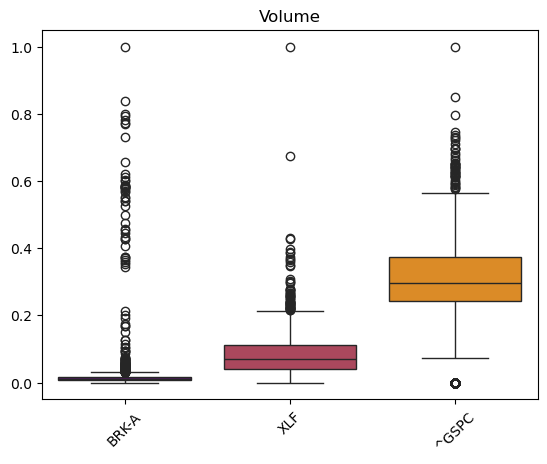

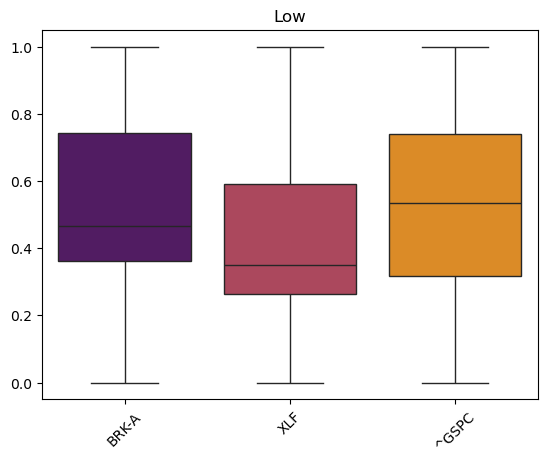

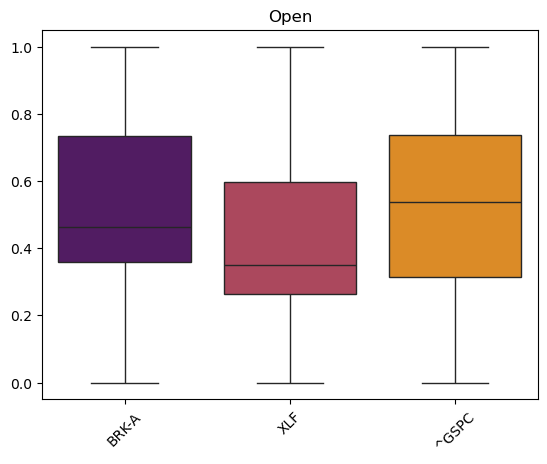

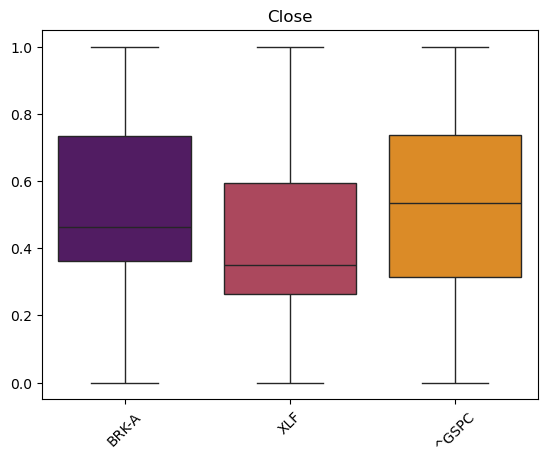

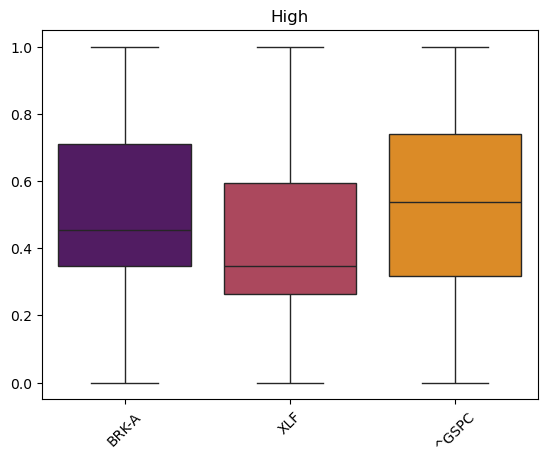

In [9]:
# seeing boxplot to visualize outliers
boxplot(BRK_A_short_data)

In [10]:
# seeing the columns with outliers
BRK_A_outlier_columns = get_columns_outliers(BRK_A_short_data)
print(BRK_A_outlier_columns)

MultiIndex([('Volume', 'BRK-A'),
            ('Volume',   'XLF'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


In [11]:
# using Winsorization to deal with outliers
for column in BRK_A_outlier_columns:
        q_lower = 0
        if column[1] == "BRK-A":
                q_upper = 0.96
        elif column[1] == "^GSPC":
                q_upper = 0.94
        else:
                q_upper = 0.90
        lower = BRK_A_short_data[column].quantile(q_lower)
        upper = BRK_A_short_data[column].quantile(q_upper)
        BRK_A_short_data[column] = BRK_A_short_data[column].clip(lower=lower, upper=upper)

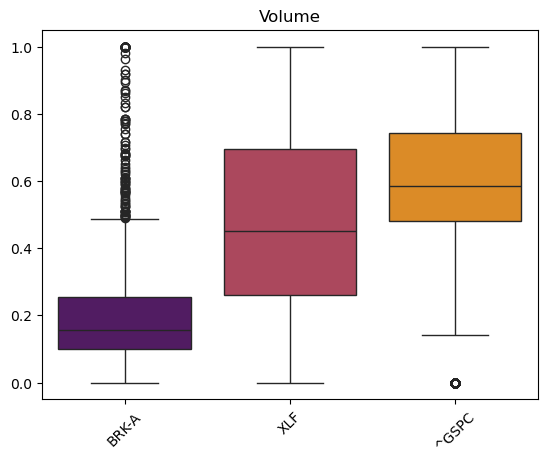

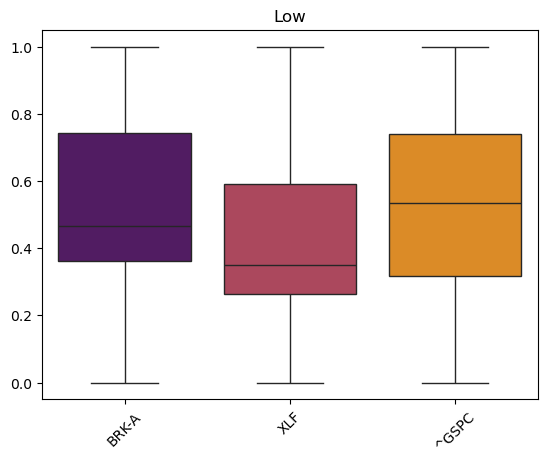

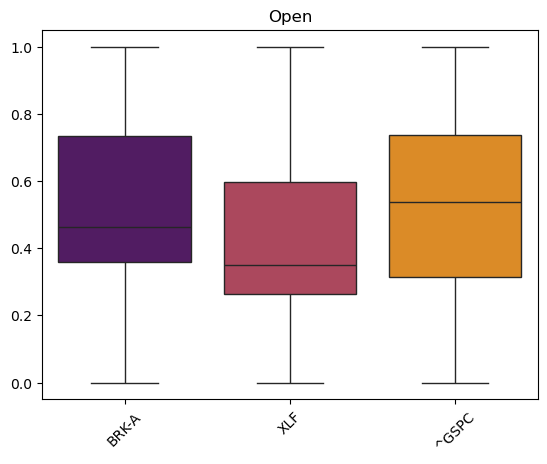

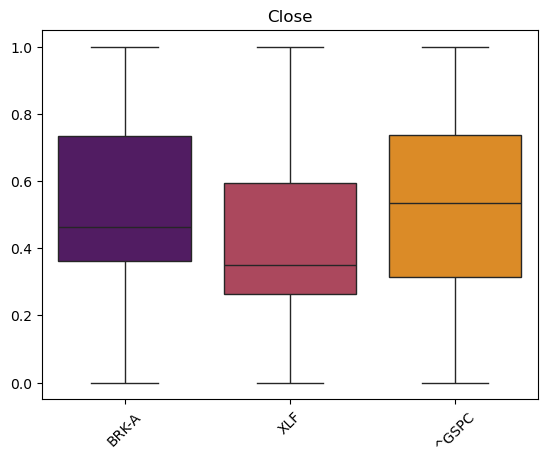

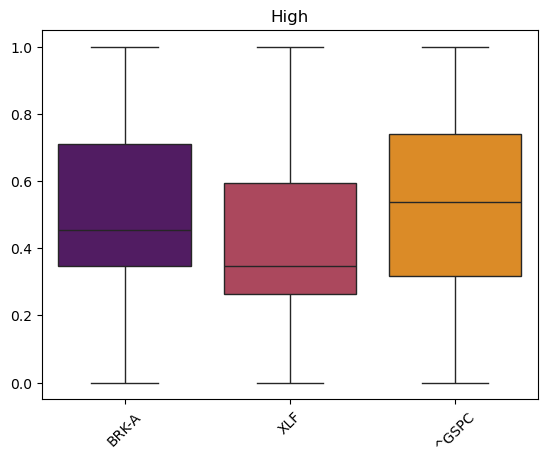

In [12]:
boxplot(BRK_A_short_data)

#### BRK-B

In [13]:
general_description(BRK_B_short_data)

Head of the data:
	 Price                           Close                                High  \
Ticker                          BRK-B        XLF        ^GSPC       BRK-B   
Datetime                                                                    
2024-01-09 14:30:00+00:00  365.549988  37.715000  4742.029785  368.000000   
2024-01-09 15:30:00+00:00  365.619995  37.755001  4749.799805  365.864990   
2024-01-09 16:30:00+00:00  365.980011  37.764999  4758.859863  366.130005   
2024-01-09 17:30:00+00:00  365.434998  37.705002  4755.279785  366.209991   
2024-01-09 18:30:00+00:00  366.100006  37.689899  4752.899902  366.440002   

Price                                                     Low             \
Ticker                           XLF        ^GSPC       BRK-B        XLF   
Datetime                                                                   
2024-01-09 14:30:00+00:00  37.790001  4746.169922  364.769989  37.633999   
2024-01-09 15:30:00+00:00  37.759998  4749.990234  365.2799

In [14]:
BRK_B_short_data.ffill(inplace=True)

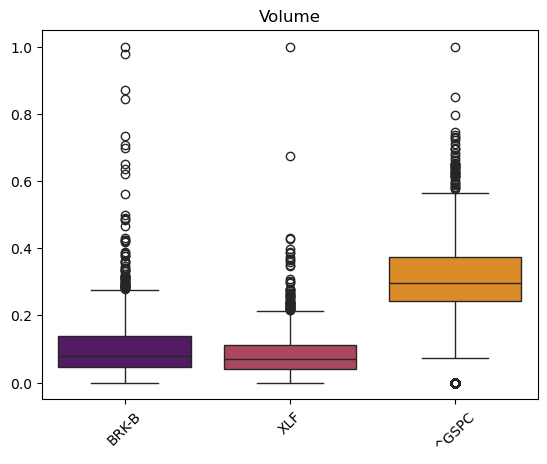

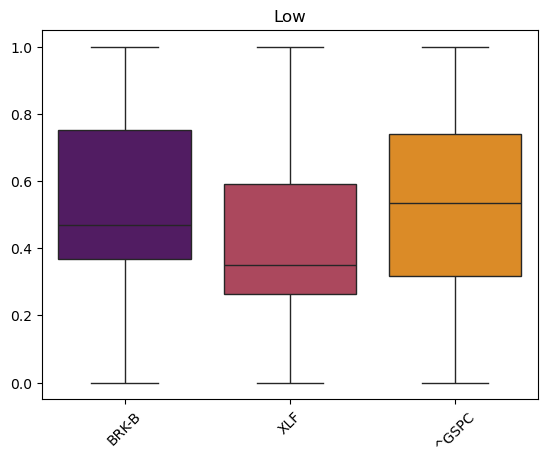

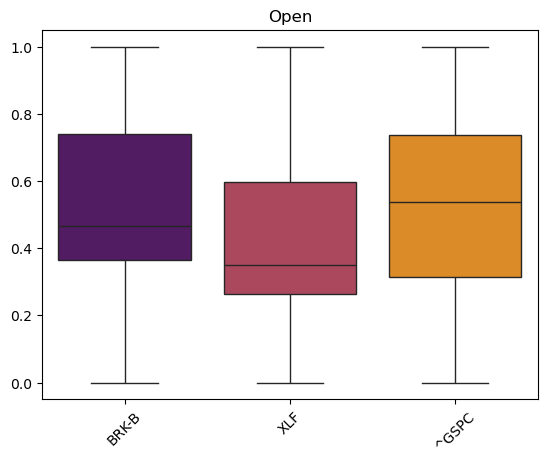

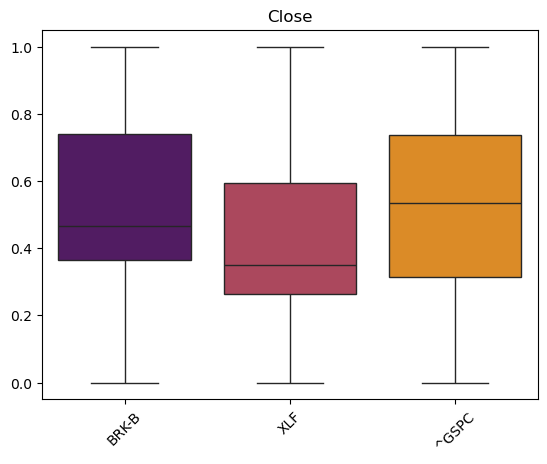

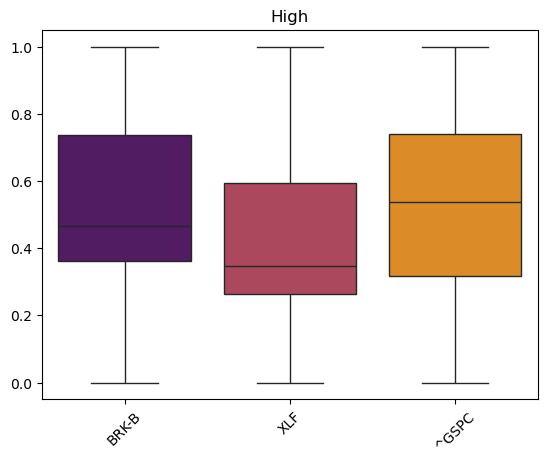

In [15]:
boxplot(BRK_B_short_data)

In [16]:
BRK_B_outlier_columns = get_columns_outliers(BRK_B_short_data)
print(BRK_A_outlier_columns)

MultiIndex([('Volume', 'BRK-A'),
            ('Volume',   'XLF'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


In [17]:
# using Winsorization to deal with outliers
for column in BRK_B_outlier_columns:
        q_lower = 0
        if column[1] == "BRK-B":
                q_upper = 0.92
        elif column[1] == "^GSPC":
                q_upper = 0.94
        else:
                q_upper = 0.90
        lower = BRK_B_short_data[column].quantile(q_lower)
        upper = BRK_B_short_data[column].quantile(q_upper)
        BRK_B_short_data[column] = BRK_B_short_data[column].clip(lower=lower, upper=upper)

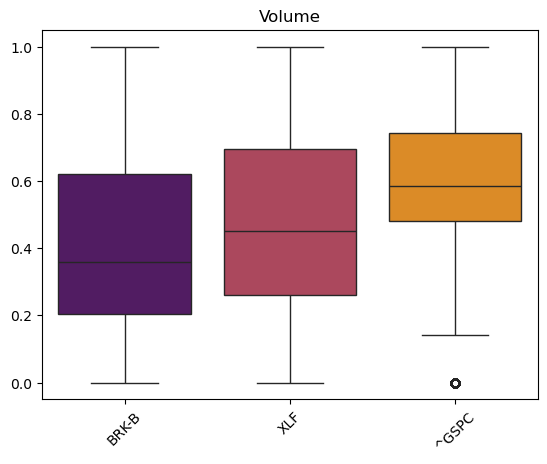

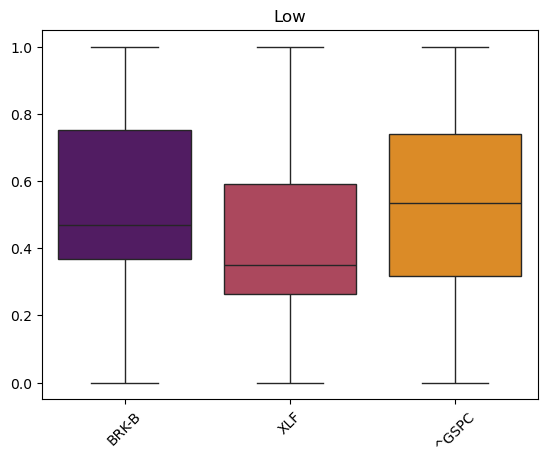

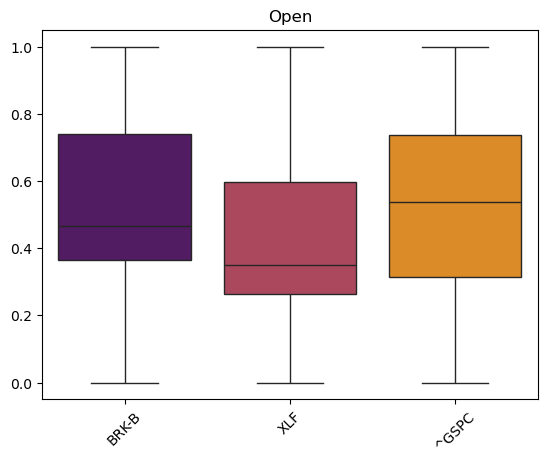

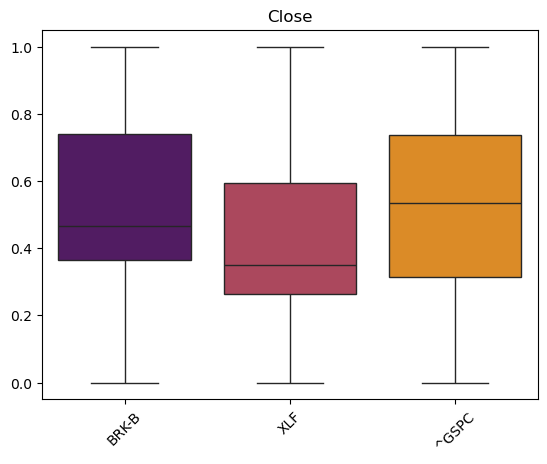

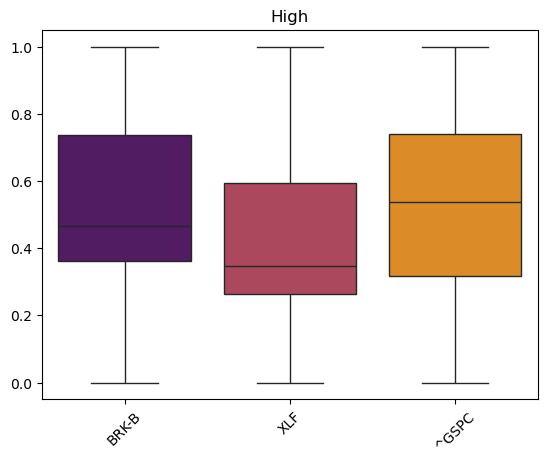

In [18]:
boxplot(BRK_B_short_data)

### ORACLE

In [19]:
general_description(ORACLE_short_data)

Head of the data:
	 Price                           Close                                 High  \
Ticker                           ORCL         XLK        ^GSPC        ORCL   
Datetime                                                                     
2024-01-09 14:30:00+00:00  104.250000  187.850006  4742.029785  104.480003   
2024-01-09 15:30:00+00:00  103.870003  188.460007  4749.799805  104.339996   
2024-01-09 16:30:00+00:00  104.000000  189.070007  4758.859863  104.099998   
2024-01-09 17:30:00+00:00  103.480003  189.080002  4755.279785  104.050003   
2024-01-09 18:30:00+00:00  103.389999  188.950104  4752.899902  103.620003   

Price                                                      Low              \
Ticker                            XLK        ^GSPC        ORCL         XLK   
Datetime                                                                     
2024-01-09 14:30:00+00:00  188.080002  4746.169922  103.550003  186.889999   
2024-01-09 15:30:00+00:00  188.490005  4749

In [20]:
# dealing wit missing values
ORACLE_short_data.ffill(inplace=True)

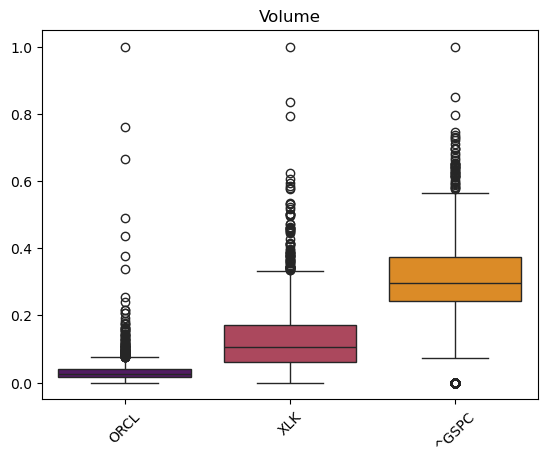

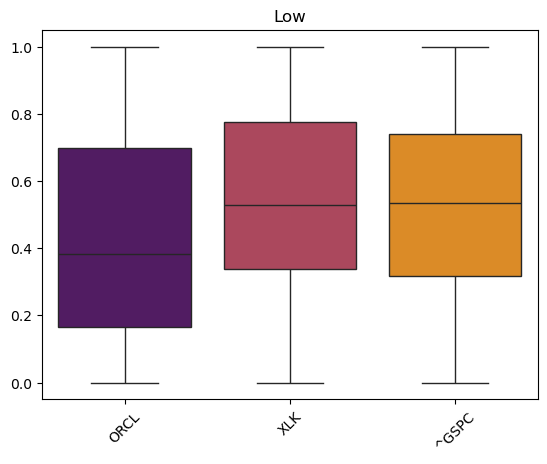

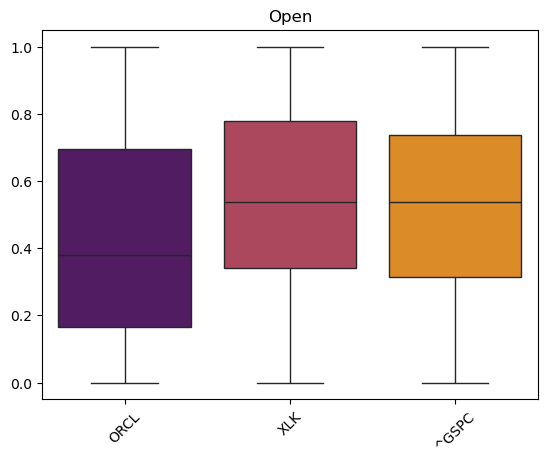

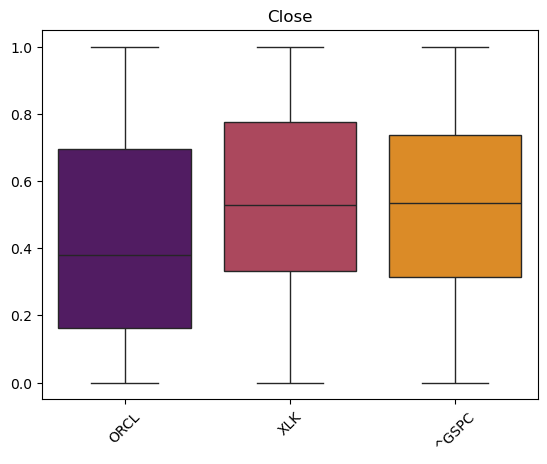

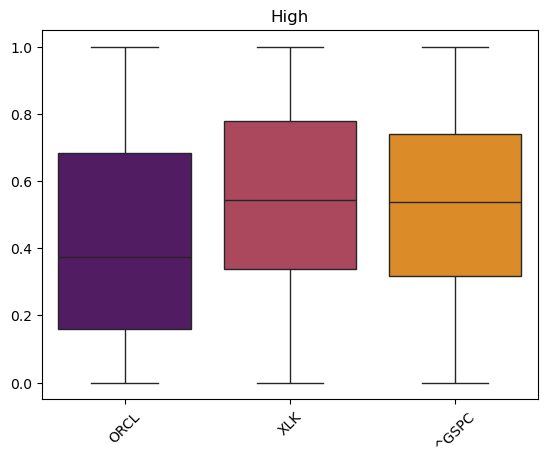

In [21]:
boxplot(ORACLE_short_data)

In [22]:
ORACLE_outlier_columns = get_columns_outliers(ORACLE_short_data)
print(ORACLE_outlier_columns)

MultiIndex([('Volume',  'ORCL'),
            ('Volume',   'XLK'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


In [23]:
# using Winsorization to deal with outliers
for column in ORACLE_outlier_columns:
        q_lower = 0
        if column[0] == "Volume":
                if column[1] == "ORCL":
                        q_upper = 0.91
                elif column[1] == "XLK":
                        q_upper = 0.90
                else:
                        q_upper = 0.94
        else:
                q_upper = 0.93
        lower = ORACLE_short_data[column].quantile(q_lower)
        upper = ORACLE_short_data[column].quantile(q_upper)
        ORACLE_short_data[column] = ORACLE_short_data[column].clip(lower=lower, upper=upper)

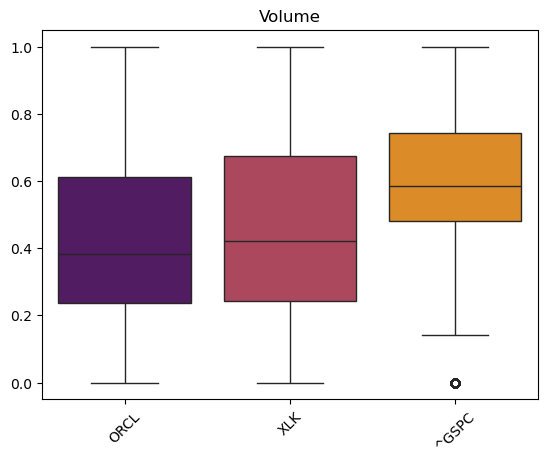

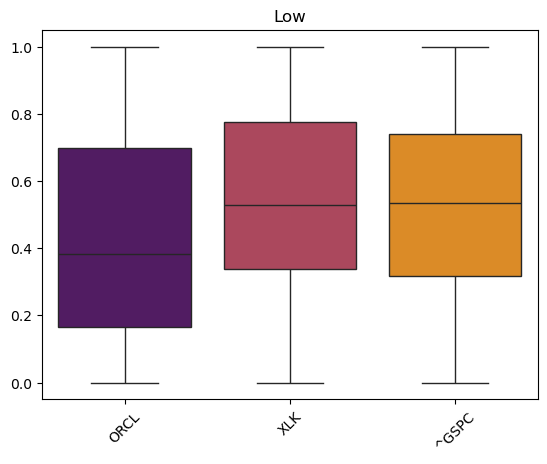

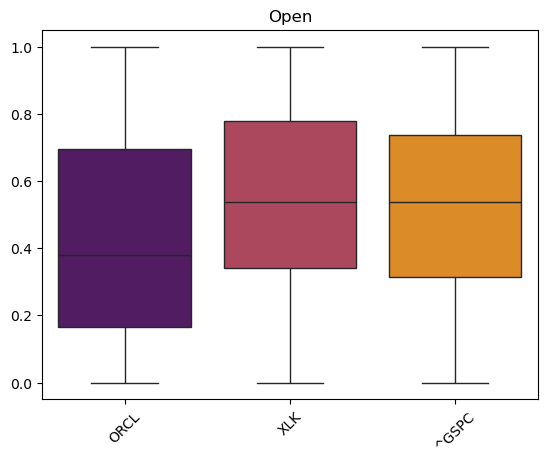

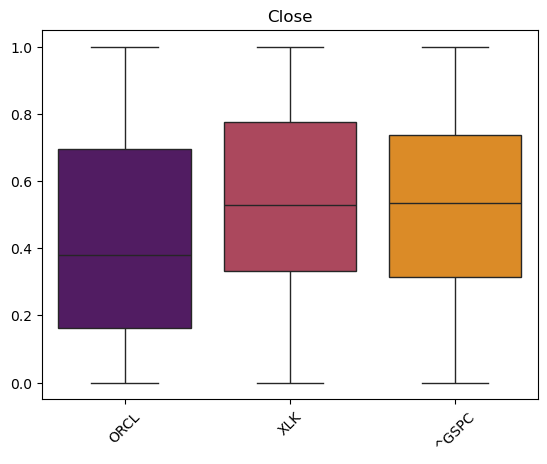

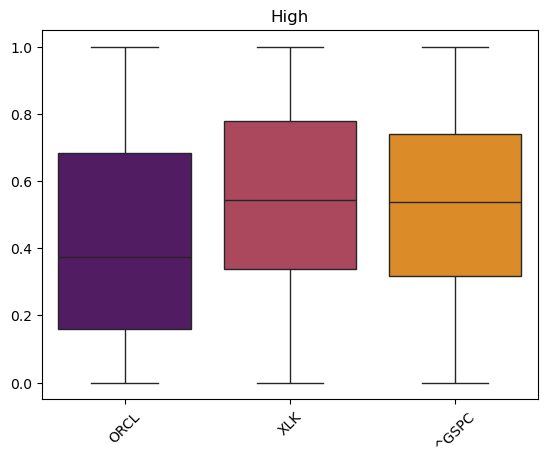

In [24]:
boxplot(ORACLE_short_data)

### META

In [25]:
general_description(META_short_data)

Head of the data:
	 Price                           Close                                  High  \
Ticker                           META         XLK         ^IXIC        META   
Datetime                                                                      
2024-01-09 14:30:00+00:00  358.369995  187.850006  14769.126953  358.549988   
2024-01-09 15:30:00+00:00  358.559998  188.460007  14820.863281  359.739990   
2024-01-09 16:30:00+00:00  359.369995  189.070007  14860.784180  360.640015   
2024-01-09 17:30:00+00:00  358.734985  189.080002  14861.980469  359.899994   
2024-01-09 18:30:00+00:00  358.209991  188.950104  14851.020508  358.959991   

Price                                                       Low              \
Ticker                            XLK         ^IXIC        META         XLK   
Datetime                                                                      
2024-01-09 14:30:00+00:00  188.080002  14789.148438  355.359985  186.889999   
2024-01-09 15:30:00+00:00  188.

In [26]:
META_short_data.ffill(inplace=True)

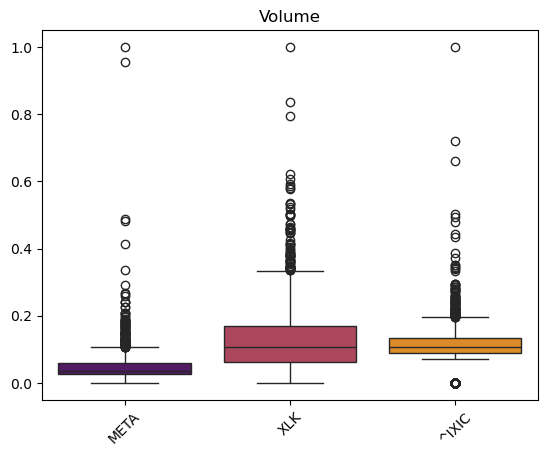

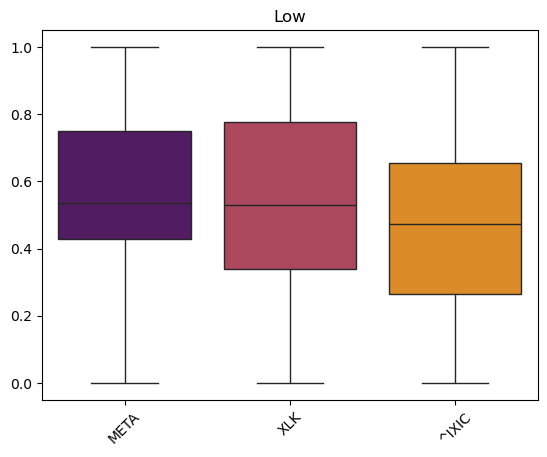

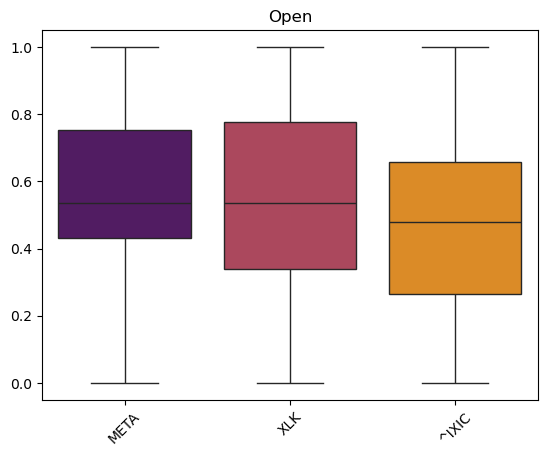

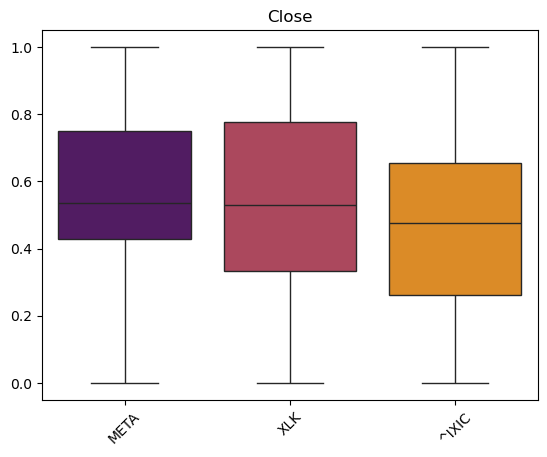

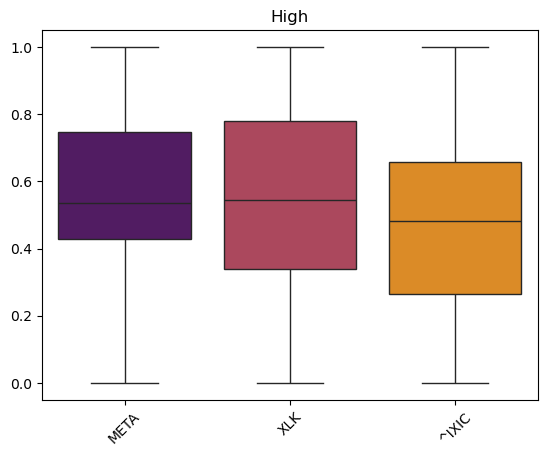

In [27]:
boxplot(META_short_data)

In [28]:
META_outlier_columns = get_columns_outliers(META_short_data)
print(META_outlier_columns)

MultiIndex([('Volume',  'META'),
            ('Volume',   'XLK'),
            ('Volume', '^IXIC')],
           names=['Price', 'Ticker'])


In [29]:
# using Winsorization to deal with outliers
for column in META_outlier_columns:
        q_lower = 0
        if column[1] == "META":
                q_upper = 0.91
        elif column[1] == "XLK":
                q_upper = 0.90
        else:
                q_upper = 0.94
        lower = META_short_data[column].quantile(q_lower)
        upper = META_short_data[column].quantile(q_upper)
        META_short_data[column] = META_short_data[column].clip(lower=lower, upper=upper)

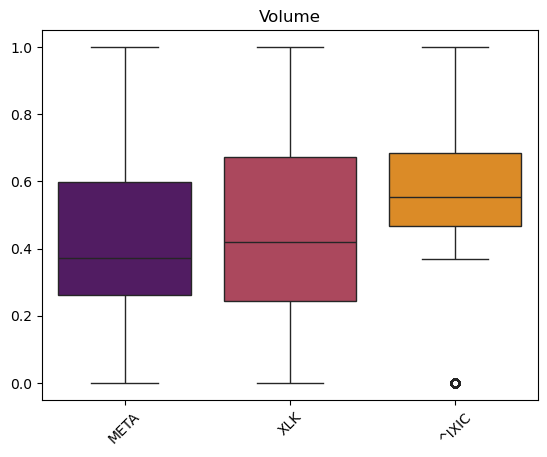

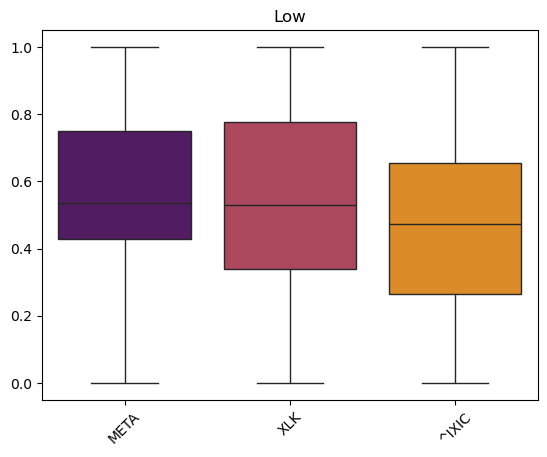

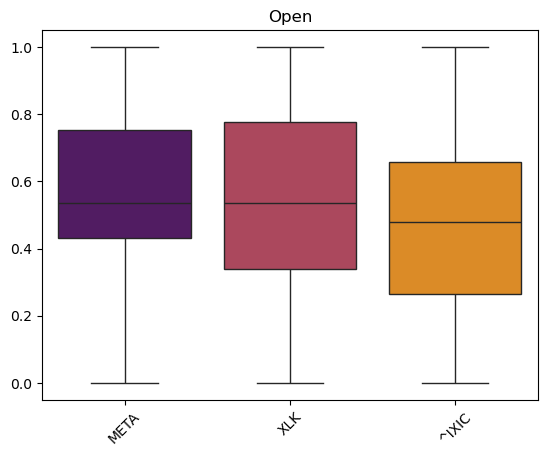

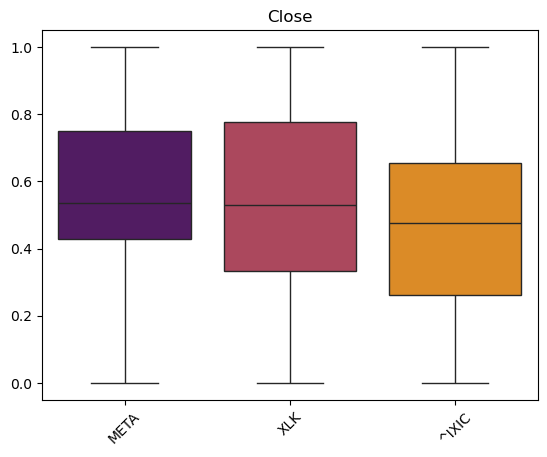

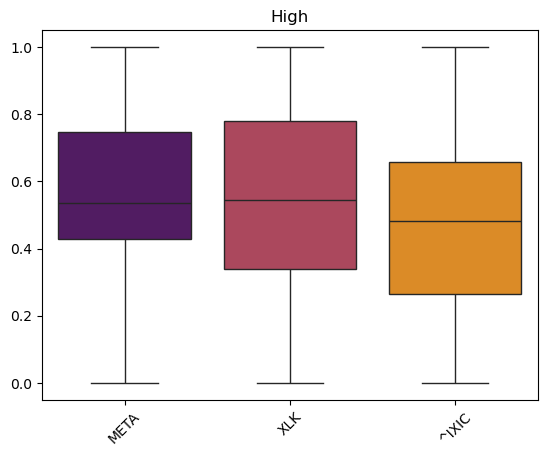

In [30]:
boxplot(META_short_data)

### COCA

In [31]:
general_description(COCA_short_data)

Head of the data:
	 Price                          Close                               High  \
Ticker                            KO        XLP        ^GSPC         KO   
Datetime                                                                  
2024-01-09 14:30:00+00:00  60.009998  72.294998  4742.029785  60.029999   
2024-01-09 15:30:00+00:00  60.025002  72.379997  4749.799805  60.134998   
2024-01-09 16:30:00+00:00  59.884998  72.389999  4758.859863  60.070000   
2024-01-09 17:30:00+00:00  59.790001  72.324997  4755.279785  59.910000   
2024-01-09 18:30:00+00:00  59.799999  72.470001  4752.899902  59.930000   

Price                                                    Low             \
Ticker                           XLP        ^GSPC         KO        XLP   
Datetime                                                                  
2024-01-09 14:30:00+00:00  72.385002  4746.169922  59.619999  72.010002   
2024-01-09 15:30:00+00:00  72.426804  4749.990234  59.980000  72.285004   
2024

In [32]:
COCA_short_data.ffill(inplace=True)

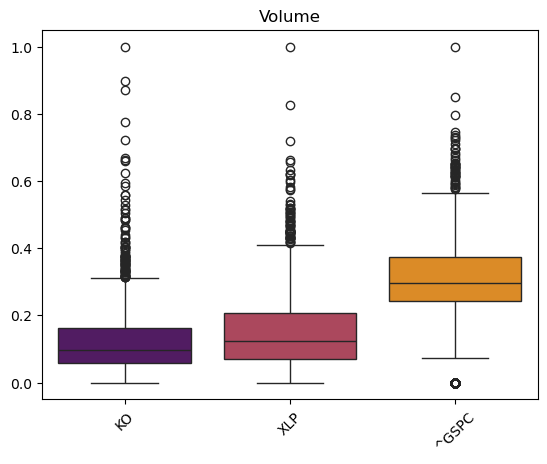

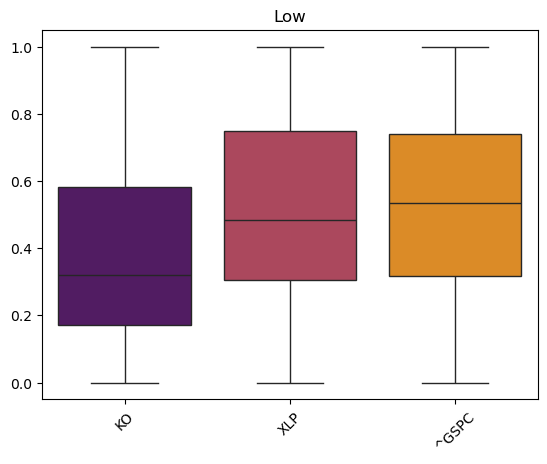

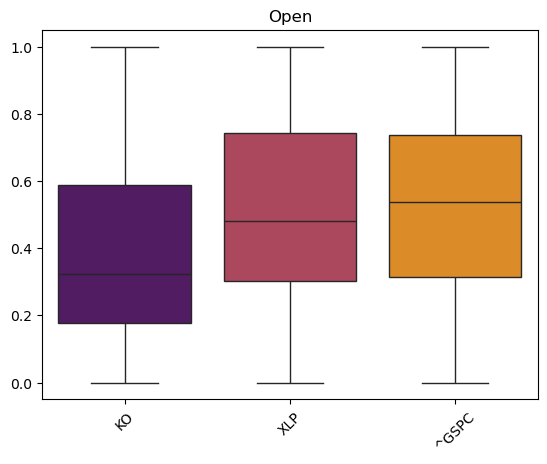

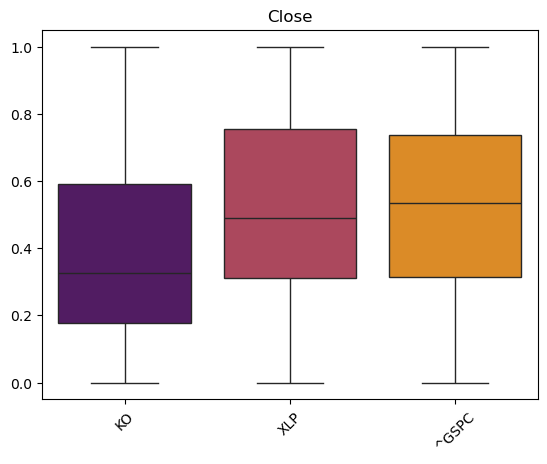

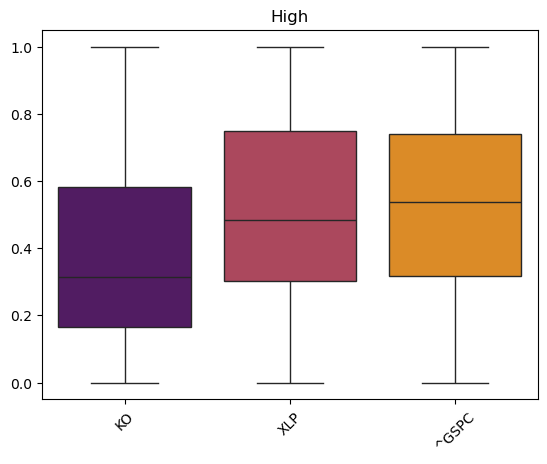

In [33]:
boxplot(COCA_short_data)

In [34]:
COCA_outlier_columns = get_columns_outliers(COCA_short_data)
print(COCA_outlier_columns)

MultiIndex([('Volume',    'KO'),
            ('Volume',   'XLP'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


In [35]:
# using Winsorization to deal with outliers
for column in COCA_outlier_columns:
        q_lower = 0
        if column[1] == "KO":
                q_upper = 0.92
        elif column[1] == "^GSPC":
                q_upper = 0.94
        else:
                q_upper = 0.89
        lower = COCA_short_data[column].quantile(q_lower)
        upper = COCA_short_data[column].quantile(q_upper)
        COCA_short_data[column] = COCA_short_data[column].clip(lower=lower, upper=upper)

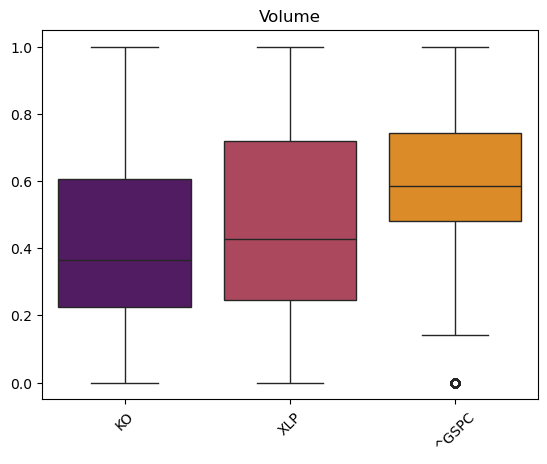

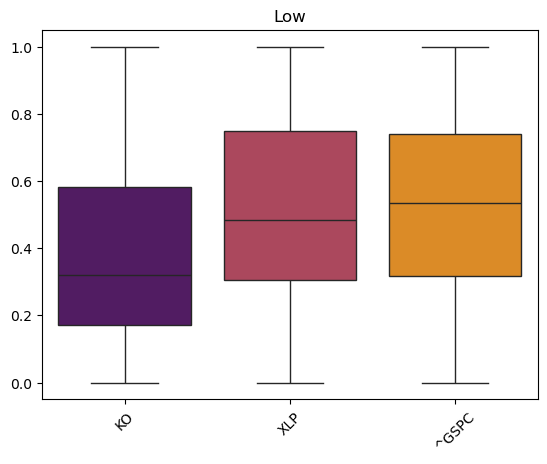

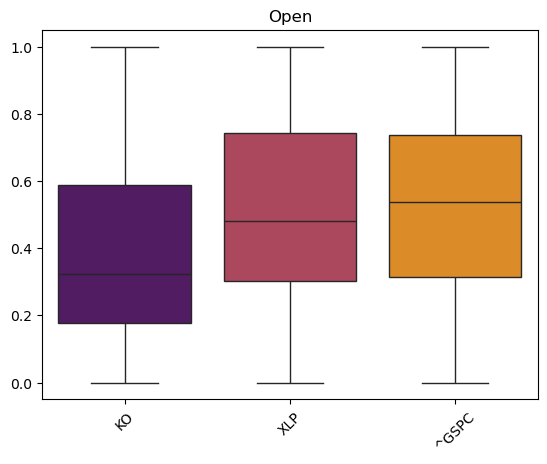

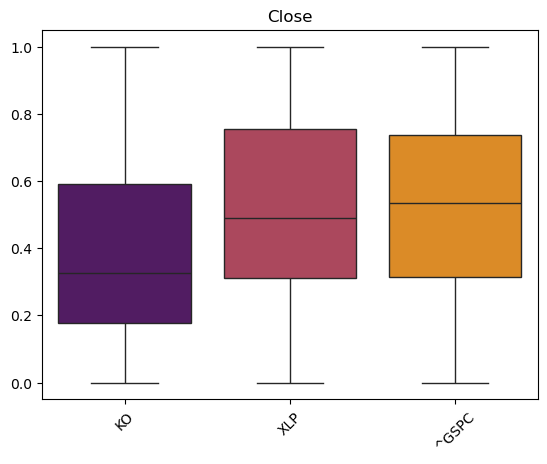

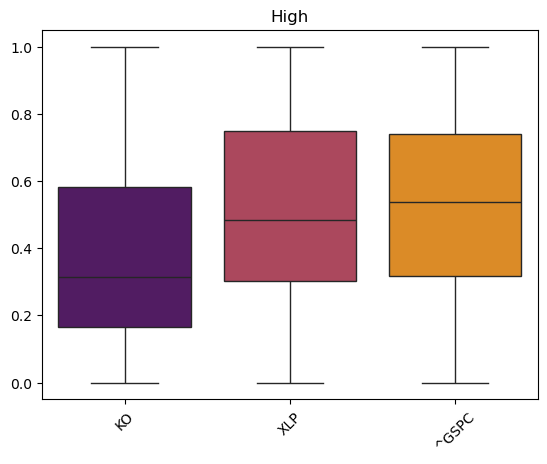

In [36]:
boxplot(COCA_short_data)

### IBM

In [37]:
general_description(IBM_short_data)

Head of the data:
	 Price                           Close                                 High  \
Ticker                            IBM         XLK        ^GSPC         IBM   
Datetime                                                                     
2024-01-09 14:30:00+00:00  160.039993  187.850006  4742.029785  160.399994   
2024-01-09 15:30:00+00:00  160.119995  188.460007  4749.799805  160.220001   
2024-01-09 16:30:00+00:00  160.339996  189.070007  4758.859863  160.483704   
2024-01-09 17:30:00+00:00  159.899994  189.080002  4755.279785  160.350006   
2024-01-09 18:30:00+00:00  159.994995  188.950104  4752.899902  160.195007   

Price                                                      Low              \
Ticker                            XLK        ^GSPC         IBM         XLK   
Datetime                                                                     
2024-01-09 14:30:00+00:00  188.080002  4746.169922  159.509995  186.889999   
2024-01-09 15:30:00+00:00  188.490005  4749

In [38]:
IBM_short_data.ffill(inplace=True)

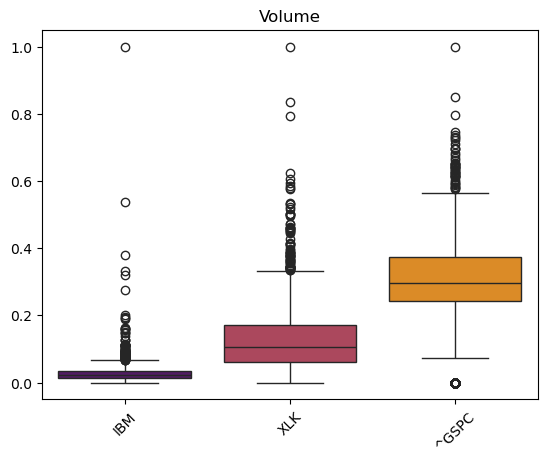

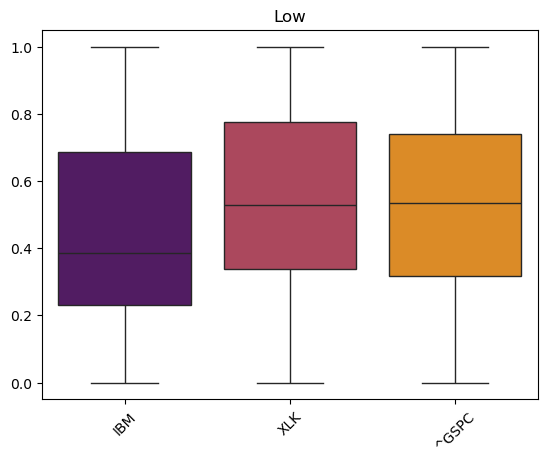

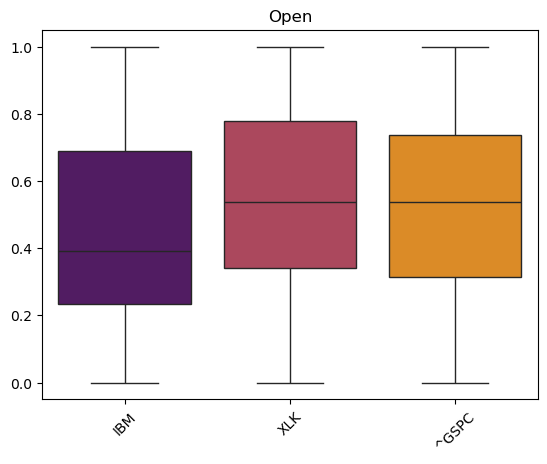

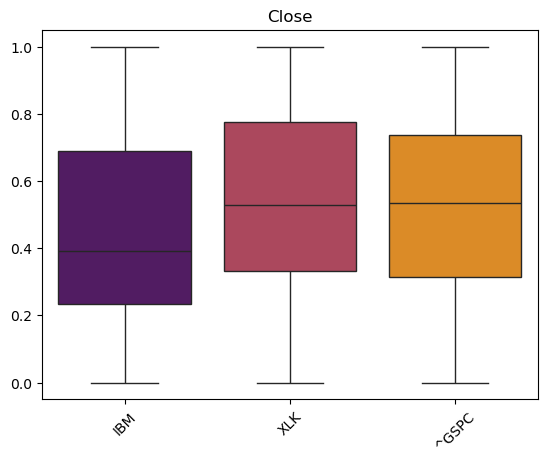

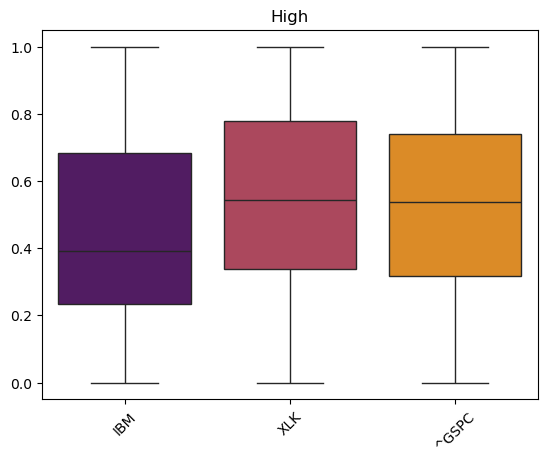

In [39]:
boxplot(IBM_short_data)

In [40]:
IBM_outlier_columns = get_columns_outliers(IBM_short_data)
print(IBM_outlier_columns)

MultiIndex([('Volume',   'IBM'),
            ('Volume',   'XLK'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


In [41]:
# using Winsorization to deal with outliers
for column in IBM_outlier_columns:
        q_lower = 0
        if column[1] == "IBM":
                q_upper = 0.91
        elif column[1] == "^GSPC":
                q_upper = 0.94
        else:
                q_upper = 0.90
        lower = IBM_short_data[column].quantile(q_lower)
        upper = IBM_short_data[column].quantile(q_upper)
        IBM_short_data[column] = IBM_short_data[column].clip(lower=lower, upper=upper)

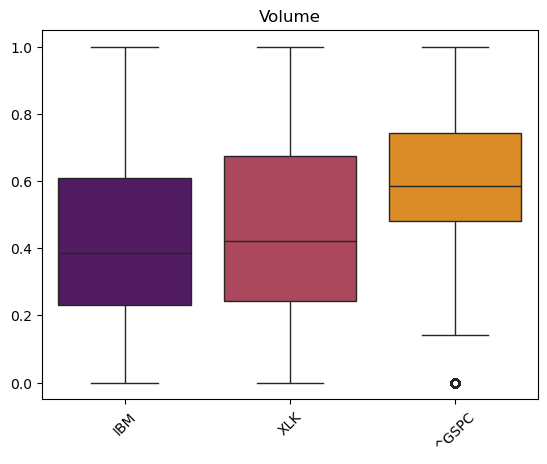

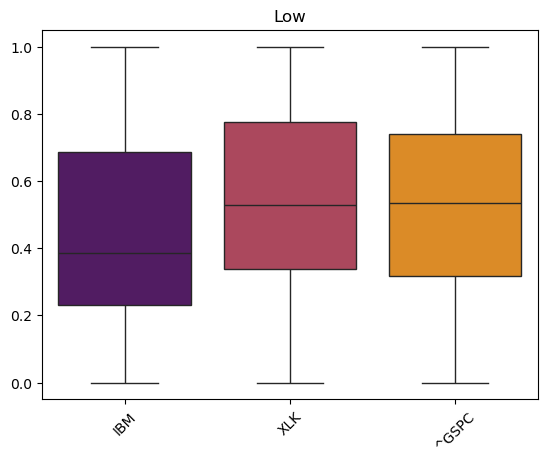

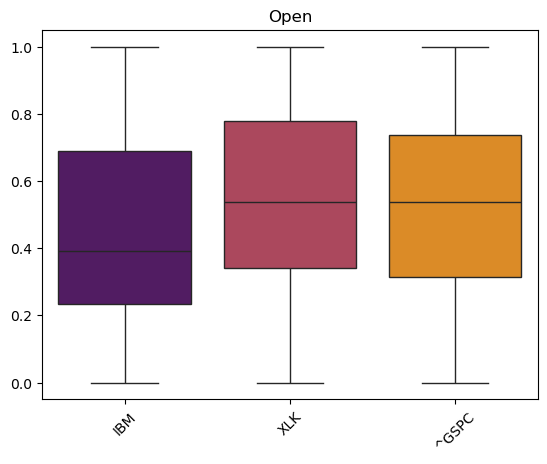

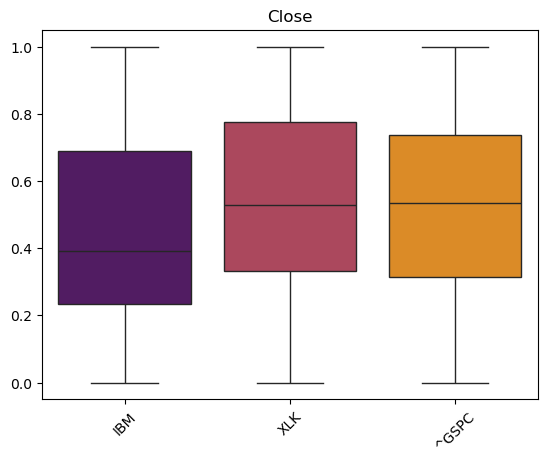

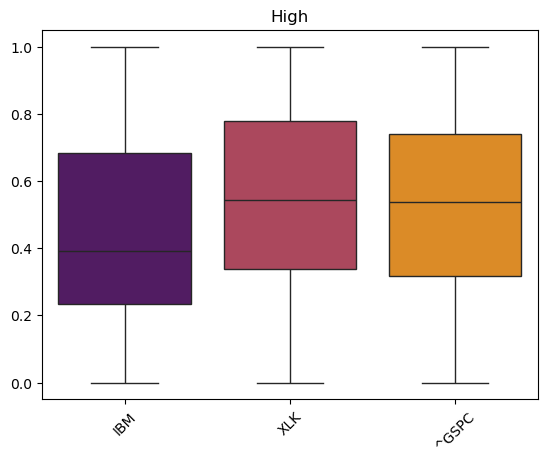

In [42]:
boxplot(IBM_short_data)

### TESLA

In [43]:
general_description(TESLA_short_data)

Head of the data:
	 Price                           Close                                  High  \
Ticker                           TSLA         XLY         ^IXIC        TSLA   
Datetime                                                                      
2024-01-09 14:30:00+00:00  232.324997  174.059998  14769.126953  238.964600   
2024-01-09 15:30:00+00:00  234.295197  174.539993  14820.863281  235.289993   
2024-01-09 16:30:00+00:00  234.919998  174.835007  14860.784180  235.580002   
2024-01-09 17:30:00+00:00  234.154602  174.779999  14861.980469  235.429993   
2024-01-09 18:30:00+00:00  233.898804  174.619995  14851.020508  235.139999   

Price                                                       Low              \
Ticker                            XLY         ^IXIC        TSLA         XLY   
Datetime                                                                      
2024-01-09 14:30:00+00:00  174.820007  14789.148438  232.039993  173.830002   
2024-01-09 15:30:00+00:00  174.

In [44]:
TESLA_short_data.ffill(inplace=True)

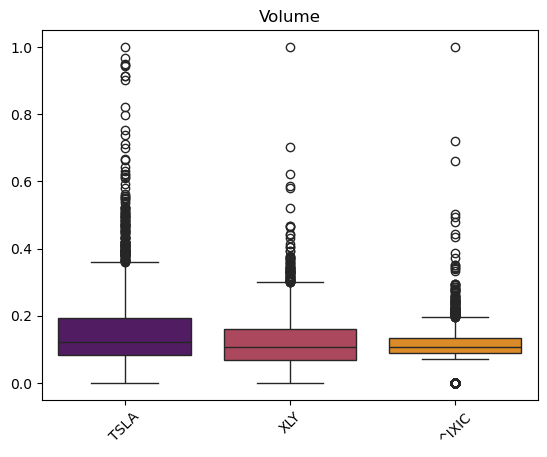

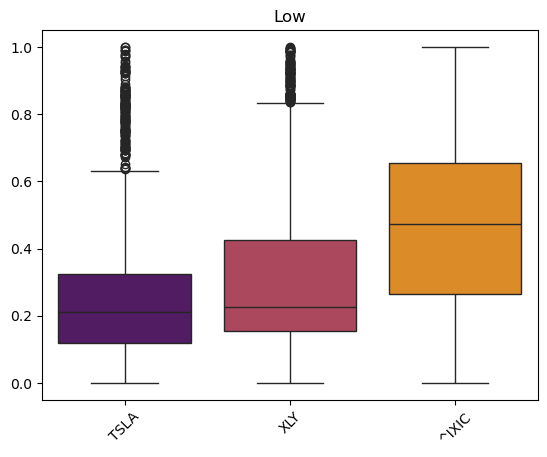

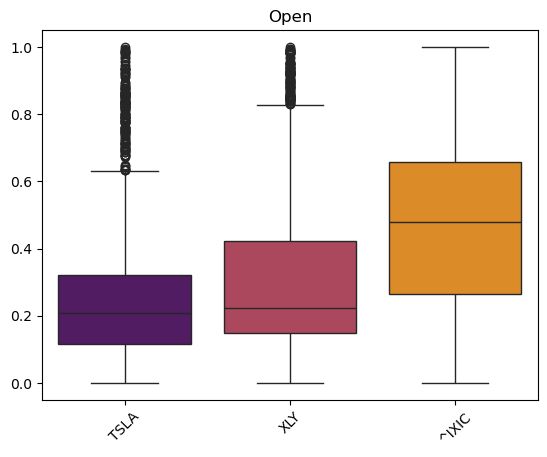

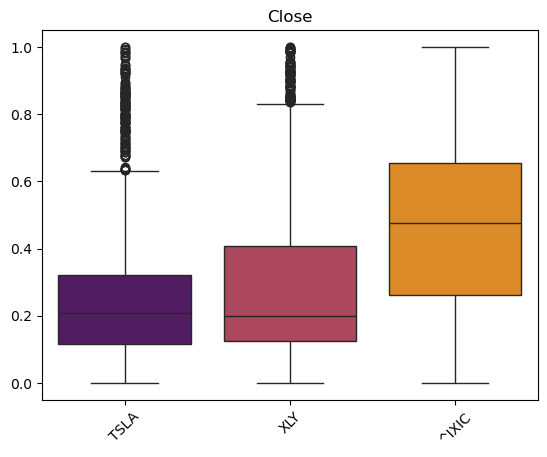

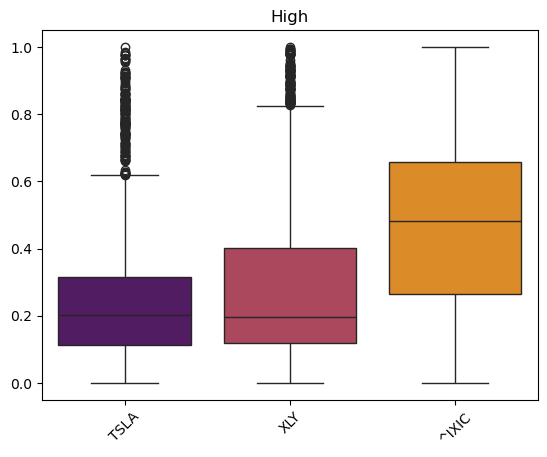

In [45]:
boxplot(TESLA_short_data)

In [46]:
TESLA_outlier_columns = get_columns_outliers(TESLA_short_data)
print(TESLA_outlier_columns)

MultiIndex([( 'Close',  'TSLA'),
            ( 'Close',   'XLY'),
            (  'High',  'TSLA'),
            (  'High',   'XLY'),
            (   'Low',  'TSLA'),
            (   'Low',   'XLY'),
            (  'Open',  'TSLA'),
            (  'Open',   'XLY'),
            ('Volume',  'TSLA'),
            ('Volume',   'XLY'),
            ('Volume', '^IXIC')],
           names=['Price', 'Ticker'])


In [47]:
# using Winsorization to deal with outliers
for column in TESLA_outlier_columns:
        q_lower = 0
        if column[1] == "TSLA":
                q_upper = 0.93
        elif column[1] == "^IXIC":
                q_upper = 0.94
        else:
                q_upper = 0.90
        lower = TESLA_short_data[column].quantile(q_lower)
        upper = TESLA_short_data[column].quantile(q_upper)
        TESLA_short_data[column] = TESLA_short_data[column].clip(lower=lower, upper=upper)

C:\Users\hp\AppData\Local\Temp\ipykernel_3348\1315729374.py:12: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  TESLA_short_data[column] = TESLA_short_data[column].clip(lower=lower, upper=upper)


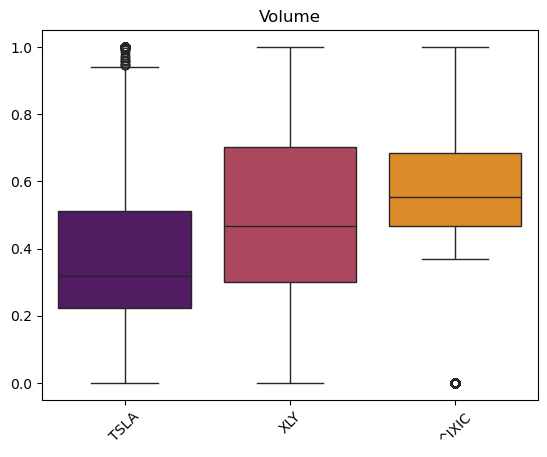

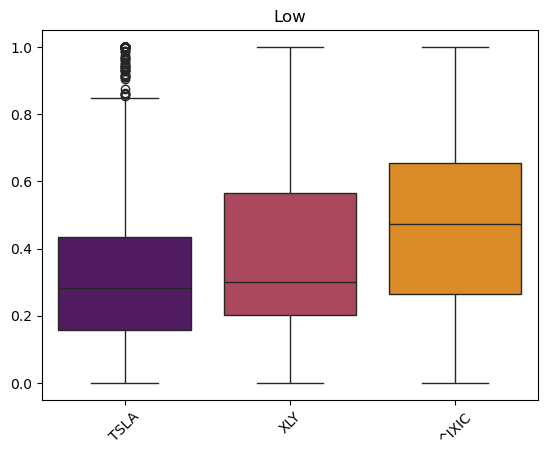

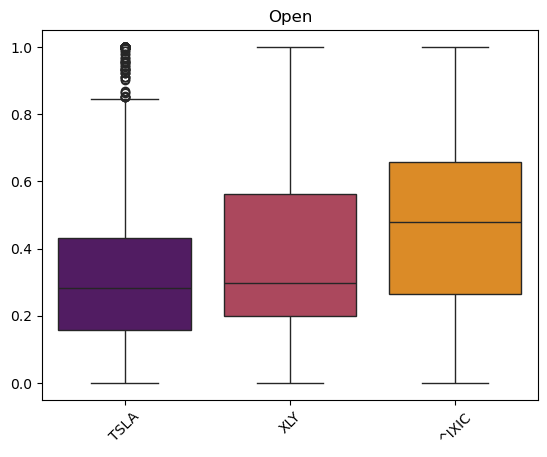

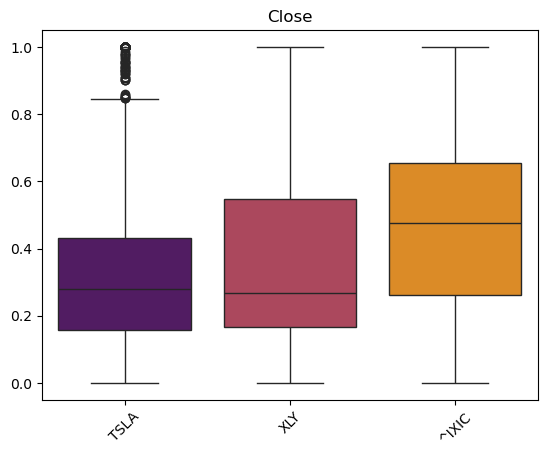

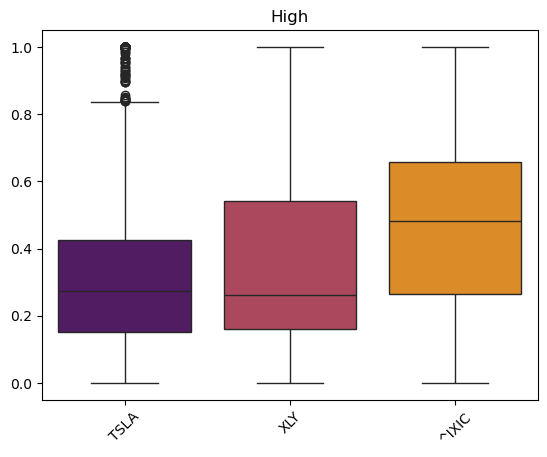

In [48]:
boxplot(TESLA_short_data)

# EDA

### Univariate EDA

##### Last week's Summary statistics

In [49]:
# getting last weeks summary statistics
def week_summary(data):
    """
    Prints summary statistics  for the past week (7 days) of a stock.

    Parameters:
    data (pandas.DataFrame): The stock data dataframe with a datetime index.
 
    Returns:
    None: The function prints the summary statistics directly.
    """
    data = pd.DataFrame(data)
    index_start = data.index.max() - pd.Timedelta("7d")
    print(data[index_start :].describe())

In [50]:
week_summary(BRK_A_short_data)

Price           Close                                   High             \
Ticker          BRK-A        XLF        ^GSPC          BRK-A        XLF   
count       35.000000  35.000000    35.000000      35.000000  35.000000   
mean    679257.689286  48.451237  5927.561119  680702.516071  48.566449   
std       2378.100526   0.208034    44.481971    2484.187092   0.199960   
min     675335.250000  48.040001  5846.500000  676662.500000  48.180000   
25%     677248.375000  48.297550  5901.969971  678612.531250  48.442499   
50%     679169.500000  48.465000  5925.089844  680539.062500  48.529999   
75%     681296.250000  48.560001  5950.004883  682808.062500  48.695000   
max     683700.000000  48.910000  6018.770020  685329.937500  49.020000   

Price                          Low                                   Open  \
Ticker        ^GSPC          BRK-A        XLF        ^GSPC          BRK-A   
count     35.000000      35.000000  35.000000    35.000000      35.000000   
mean    5939.59656

In [51]:
week_summary(BRK_B_short_data)

Price        Close                                High             \
Ticker       BRK-B        XLF        ^GSPC       BRK-B        XLF   
count    35.000000  35.000000    35.000000   35.000000  35.000000   
mean    452.897820  48.451237  5927.561119  453.880371  48.566449   
std       1.584940   0.208034    44.481971    1.607449   0.199960   
min     450.100006  48.040001  5846.500000  451.290009  48.180000   
25%     451.639999  48.297550  5901.969971  452.538452  48.442499   
50%     452.890015  48.465000  5925.089844  453.880005  48.529999   
75%     454.302902  48.560001  5950.004883  454.979996  48.695000   
max     455.797485  48.910000  6018.770020  456.889893  49.020000   

Price                       Low                                Open  \
Ticker        ^GSPC       BRK-B        XLF        ^GSPC       BRK-B   
count     35.000000   35.000000  35.000000    35.000000   35.000000   
mean    5939.596568  451.903533  48.321637  5913.565151  453.107775   
std       42.559482    1.

In [52]:
week_summary(ORACLE_short_data)

Price        Close                                 High              \
Ticker        ORCL         XLK        ^GSPC        ORCL         XLK   
count    35.000000   35.000000    35.000000   35.000000   35.000000   
mean    164.791532  235.133138  5927.561119  165.452454  235.834932   
std       1.823686    2.771378    44.481971    1.803434    2.696083   
min     161.634995  230.660004  5846.500000  162.130005  231.279999   
25%     162.928749  233.410004  5901.969971  163.714951  234.283203   
50%     165.740005  234.589996  5925.089844  166.160004  235.330002   
75%     166.187500  236.434998  5950.004883  166.642097  236.935051   
max     167.449997  240.964996  6018.770020  168.690002  241.061996   

Price                       Low                                 Open  \
Ticker        ^GSPC        ORCL         XLK        ^GSPC        ORCL   
count     35.000000   35.000000   35.000000    35.000000   35.000000   
mean    5939.596568  164.274830  234.333008  5913.565151  164.989331   
s

In [53]:
week_summary(META_short_data)

Price        Close                                  High              \
Ticker        META         XLK         ^IXIC        META         XLK   
count    35.000000   35.000000     35.000000   35.000000   35.000000   
mean    610.074125  235.133138  19559.734263  613.197102  235.834932   
std      10.071451    2.771378    221.198299   10.620717    2.696083   
min     593.049988  230.660004  19179.369141  594.780029  231.279999   
25%     601.027985  233.410004  19430.331055  604.954987  234.283203   
50%     610.859985  234.589996  19532.531250  613.858276  235.330002   
75%     619.084991  236.434998  19655.392578  622.154999  236.935051   
max     630.270020  240.964996  19998.304688  632.101074  241.061996   

Price                        Low                                  Open  \
Ticker         ^IXIC        META         XLK         ^IXIC        META   
count      35.000000   35.000000   35.000000     35.000000   35.000000   
mean    19611.354743  606.233573  234.333008  19499.29765

In [54]:
week_summary(COCA_short_data)

Price       Close                               High                          \
Ticker         KO        XLP        ^GSPC         KO        XLP        ^GSPC   
count   35.000000  35.000000    35.000000  35.000000  35.000000    35.000000   
mean    61.450992  77.879897  5927.561119  61.611306  78.039715  5939.596568   
std      0.463708   0.581083    44.481971   0.461466   0.594967    42.559482   
min     60.665001  76.824997  5846.500000  60.840000  77.110001  5857.890137   
25%     61.075001  77.392502  5901.969971  61.295000  77.472500  5914.594971   
50%     61.459999  77.870003  5925.089844  61.639999  78.160004  5933.520020   
75%     61.887501  78.404999  5950.004883  61.977501  78.525002  5957.390137   
max     62.330002  78.769997  6018.770020  62.750000  79.139999  6021.040039   

Price         Low                               Open                          \
Ticker         KO        XLP        ^GSPC         KO        XLP        ^GSPC   
count   35.000000  35.000000    35.0000

In [55]:
week_summary(IBM_short_data)

Price        Close                                 High              \
Ticker         IBM         XLK        ^GSPC         IBM         XLK   
count    35.000000   35.000000    35.000000   35.000000   35.000000   
mean    222.333134  235.133138  5927.561119  223.083282  235.834932   
std       1.948785    2.771378    44.481971    1.995425    2.696083   
min     218.425003  230.660004  5846.500000  218.699997  231.279999   
25%     221.332497  233.410004  5901.969971  222.445000  234.283203   
50%     222.539993  234.589996  5925.089844  222.979996  235.330002   
75%     223.349998  236.434998  5950.004883  224.199997  236.935051   
max     226.059998  240.964996  6018.770020  226.710999  241.061996   

Price                       Low                                 Open  \
Ticker        ^GSPC         IBM         XLK        ^GSPC         IBM   
count     35.000000   35.000000   35.000000    35.000000   35.000000   
mean    5939.596568  221.566779  234.333008  5913.565151  222.326668   
s

In [56]:
week_summary(TESLA_short_data)

Price        Close                                  High              \
Ticker        TSLA         XLY         ^IXIC        TSLA         XLY   
count    35.000000   35.000000     35.000000   35.000000   35.000000   
mean    390.720731  221.584285  19559.734263  394.594660  222.160404   
std       6.140607    0.199187    221.198299    6.321956    0.197789   
min     377.227295  220.720001  19179.369141  379.059998  221.300003   
25%     389.770004  221.651999  19430.331055  394.639999  222.225005   
50%     394.271599  221.651999  19532.531250  398.135538  222.225005   
75%     394.271599  221.651999  19655.392578  398.135538  222.225005   
max     394.271599  221.651999  19998.304688  398.135538  222.225005   

Price                        Low                                  Open  \
Ticker         ^IXIC        TSLA         XLY         ^IXIC        TSLA   
count      35.000000   35.000000   35.000000     35.000000   35.000000   
mean    19611.354743  387.000675  221.076913  19499.29765

##### Last month's summary statistics

In [57]:
# getting last month's summary statistics
# each data is already one month long

BRK_A_short_data.describe()

Price           Close                                     High               \
Ticker          BRK-A          XLF        ^GSPC          BRK-A          XLF   
count     1752.000000  1752.000000  1752.000000    1752.000000  1752.000000   
mean    644540.923302    43.391438  5449.392975  646089.750036    43.471803   
std      42390.462342     3.595966   360.119143   42597.448541     3.607168   
min     543625.000000    37.014999  4722.990234  545296.562500    37.105000   
25%     612445.000000    40.840000  5157.279907  613789.140625    40.917424   
50%     632222.500000    42.093201  5459.075195  634480.000000    42.162500   
75%     683526.234375    45.649924  5736.940186  685267.750000    45.711249   
max     734464.500000    51.514999  6097.759766  741971.375000    51.619999   

Price                          Low                                     Open  \
Ticker        ^GSPC          BRK-A          XLF        ^GSPC          BRK-A   
count   1752.000000    1752.000000  1752.000000  1752.000000    1752.000000   
mean    5457.408596  642965.674051    43.305573  5440.384533  644620.086936   
std      360.580592   42339.264768     3.590633   359.998082   42472.387408   
min     4729.709961  543235.750000    36.950001  4714.819824  543800.000000   
25%     5165.445068  610995.000000    40.770000  5150.979858  612491.656250   
50%     5467.979980  630460.500000    42.007500  5448.150146  632262.500000   
75%     5744.164917  682189.234375    45.496249  5729.225220  683566.859375   
max     6099.970215  730444.250000    51.419998  6085.779785  734464.500000   

Price                                  Volume                              
Ticker          XLF        ^GSPC        BRK-A           XLF         ^GSPC  
count   1752.000000  1752.000000  1752.000000  1.752000e+03  1.752000e+03  
mean      43.390878  5449.396468   273.139361  5.041840e+06  2.178359e+08  
std        3.601298   360.360375   265.459188  2.252859e+06  1.064419e+08  
min       37.009998  4722.990234     0.000000  1.031401e+06  0.000000e+00  
25%       40.840000  5156.982544   124.000000  3.153241e+06  1.837890e+08  
50%       42.087500  5460.254883   190.000000  4.688178e+06  2.231590e+08  
75%       45.641250  5737.135010   313.250000  6.663715e+06  2.834002e+08  
max       51.485001  6097.859863  1221.960000  9.129490e+06  3.817634e+08

In [58]:
BRK_B_short_data.describe()

Price         Close                                   High               \
Ticker        BRK-B          XLF        ^GSPC        BRK-B          XLF   
count   1752.000000  1752.000000  1752.000000  1752.000000  1752.000000   
mean     428.460134    43.391438  5449.392975   429.426243    43.471803   
std       29.351564     3.595966   360.119143    29.521825     3.607168   
min      358.269989    37.014999  4722.990234   359.190002    37.105000   
25%      406.387512    40.840000  5157.279907   407.225502    40.917424   
50%      419.647507    42.093201  5459.075195   420.865005    42.162500   
75%      455.500000    45.649924  5736.940186   456.794998    45.711249   
max      489.640015    51.514999  6097.759766   491.670013    51.619999   

Price                        Low                                   Open  \
Ticker        ^GSPC        BRK-B          XLF        ^GSPC        BRK-B   
count   1752.000000  1752.000000  1752.000000  1752.000000  1752.000000   
mean    5457.408596   427.454276    43.305573  5440.384533   428.484204   
std      360.580592    29.260102     3.590633   359.998082    29.407427   
min     4729.709961   357.980011    36.950001  4714.819824   358.269989   
25%     5165.445068   405.584999    40.770000  5150.979858   406.397499   
50%     5467.979980   418.630005    42.007500  5448.150146   419.610001   
75%     5744.164917   454.760727    45.496249  5729.225220   455.614998   
max     6099.970215   486.929993    51.419998  6085.779785   489.712494   

Price                                    Volume                              
Ticker          XLF        ^GSPC          BRK-B           XLF         ^GSPC  
count   1752.000000  1752.000000    1752.000000  1.752000e+03  1.752000e+03  
mean      43.390878  5449.396468  353389.961507  5.041840e+06  2.178359e+08  
std        3.601298   360.360375  155299.535181  2.252859e+06  1.064419e+08  
min       37.009998  4722.990234  115648.000000  1.031401e+06  0.000000e+00  
25%       40.840000  5156.982544  228163.000000  3.153241e+06  1.837890e+08  
50%       42.087500  5460.254883  313359.500000  4.688178e+06  2.231590e+08  
75%       45.641250  5737.135010  456548.750000  6.663715e+06  2.834002e+08  
max       51.485001  6097.859863  665602.160000  9.129490e+06  3.817634e+08

In [59]:
ORACLE_short_data.describe()

Price         Close                                   High               \
Ticker         ORCL          XLK        ^GSPC         ORCL          XLK   
count   1752.000000  1752.000000  1752.000000  1752.000000  1752.000000   
mean     141.716127   217.307823  5449.392975   142.203997   217.855671   
std       25.606813    13.478555   360.119143    25.728167    13.484910   
min      103.389999   187.850006  4722.990234   103.599998   188.080002   
25%      118.500002   205.784996  5157.279907   118.782501   206.347504   
50%      138.460007   216.320000  5459.075195   139.040001   217.350006   
75%      167.778744   229.642498  5736.940186   168.325005   230.000000   
max      195.800003   241.639999  6097.759766   198.309906   241.880005   

Price                        Low                                   Open  \
Ticker        ^GSPC         ORCL          XLK        ^GSPC         ORCL   
count   1752.000000  1752.000000  1752.000000  1752.000000  1752.000000   
mean    5457.408596   141.234507   216.699231  5440.384533   141.734837   
std      360.580592    25.502461    13.476214   359.998082    25.625965   
min     4729.709961   102.720001   186.889999  4714.819824   103.089996   
25%     5165.445068   117.942497   205.321247  5150.979858   118.495001   
50%     5467.979980   137.932495   215.612495  5448.150146   138.559998   
75%     5744.164917   167.171227   229.032497  5729.225220   167.772503   
max     6099.970215   195.000000   241.169998  6085.779785   196.300003   

Price                                   Volume                              
Ticker          XLK        ^GSPC          ORCL           XLK         ^GSPC  
count   1752.000000  1752.000000  1.752000e+03  1.752000e+03  1.752000e+03  
mean     217.320393  5449.396468  8.048639e+05  6.792584e+05  2.178359e+08  
std       13.485831   360.360375  3.943938e+05  3.349099e+05  1.064419e+08  
min      187.289993  4722.990234  1.444390e+05  1.151260e+05  0.000000e+00  
25%      205.797501  5156.982544  4.924828e+05  4.034678e+05  1.837890e+08  
50%      216.434998  5460.254883  7.045750e+05  6.136130e+05  2.231590e+08  
75%      229.580006  5737.135010  1.040960e+06  9.134685e+05  2.834002e+08  
max      241.639999  6097.859863  1.606847e+06  1.299523e+06  3.817634e+08

In [60]:
META_short_data.describe()

Price         Close                                    High               \
Ticker         META          XLK         ^IXIC         META          XLK   
count   1752.000000  1752.000000   1752.000000  1752.000000  1752.000000   
mean     514.128513   217.307823  17333.936412   516.268748   217.855671   
std       59.341005    13.478555   1351.355111    59.538420    13.484910   
min      357.420013   187.850006  14766.129883   358.329987   188.080002   
25%      476.880005   205.784996  16189.005371   478.703903   206.347504   
50%      505.984756   216.320000  17351.059570   508.184952   217.350006   
75%      566.091263   229.642498  18330.492188   567.808716   230.000000   
max      635.093018   241.639999  20197.412109   638.400024   241.880005   

Price                         Low                                    Open  \
Ticker         ^IXIC         META          XLK         ^IXIC         META   
count    1752.000000  1752.000000  1752.000000   1752.000000  1752.000000   
mean    17368.657214   511.883729   216.699231  17294.804886   514.110273   
std      1354.025769    59.215886    13.476214   1349.548393    59.436004   
min     14789.148438   355.359985   186.889999  14706.295898   356.399994   
25%     16226.947754   474.737503   205.321247  16148.226318   476.797592   
50%     17409.502930   504.339996   215.612495  17292.954102   506.009995   
75%     18355.020996   563.639999   229.032497  18283.820312   566.177475   
max     20204.576172   633.250000   241.169998  20168.490234   635.169983   

Price                                    Volume                              
Ticker          XLK         ^IXIC          META           XLK         ^IXIC  
count   1752.000000   1752.000000  1.752000e+03  1.752000e+03  1.752000e+03  
mean     217.320393  17334.125435  1.545517e+06  6.792584e+05  4.477063e+08  
std       13.485831   1352.276564  8.640648e+05  3.349099e+05  2.205251e+08  
min      187.289993  14741.954102  0.000000e+00  1.151260e+05  0.000000e+00  
25%      205.797501  16188.913574  8.820350e+05  4.034678e+05  3.876600e+08  
50%      216.434998  17358.959961  1.251452e+06  6.136130e+05  4.592310e+08  
75%      229.580006  18329.482422  2.011116e+06  9.134685e+05  5.677012e+08  
max      241.639999  20194.298828  3.353564e+06  1.299523e+06  8.291993e+08

In [61]:
COCA_short_data.describe()

Price         Close                                   High               \
Ticker           KO          XLP        ^GSPC           KO          XLP   
count   1752.000000  1752.000000  1752.000000  1752.000000  1752.000000   
mean      64.005768    78.067104  5449.392975    64.138207    78.185952   
std        3.990830     3.326383   360.119143     4.005497     3.335272   
min       57.959999    71.580002  4722.990234    58.220001    71.690002   
25%       60.672850    75.508751  5157.279907    60.759998    75.589996   
50%       62.939999    77.779999  5459.075195    63.029999    77.887501   
75%       67.000002    81.148748  5736.940186    67.126251    81.288754   
max       73.239899    84.245003  6097.759766    73.529999    84.529999   

Price                        Low                                   Open  \
Ticker        ^GSPC           KO          XLP        ^GSPC           KO   
count   1752.000000  1752.000000  1752.000000  1752.000000  1752.000000   
mean    5457.408596    63.864746    77.940615  5440.384533    64.002576   
std      360.580592     3.977897     3.319407   359.998082     3.988867   
min     4729.709961    57.930000    71.559998  4714.819824    57.959999   
25%     5165.445068    60.529999    75.413752  5150.979858    60.661251   
50%     5467.979980    62.782499    77.675003  5448.150146    62.937500   
75%     5744.164917    66.792501    81.006248  5729.225220    66.992498   
max     6099.970215    73.125000    84.169998  6085.779785    73.300003   

Price                                   Volume                              
Ticker          XLP        ^GSPC            KO           XLP         ^GSPC  
count   1752.000000  1752.000000  1.752000e+03  1.752000e+03  1.752000e+03  
mean      78.065253  5449.396468  1.327336e+06  1.332811e+06  2.178359e+08  
std        3.328482   360.360375  6.058946e+05  6.676488e+05  1.064419e+08  
min       71.589996  4722.990234  3.548630e+05  2.146950e+05  0.000000e+00  
25%       75.498751  5156.982544  8.480868e+05  7.729550e+05  1.837890e+08  
50%       77.774998  5460.254883  1.156450e+06  1.191944e+06  2.231590e+08  
75%       81.145000  5737.135010  1.691011e+06  1.858893e+06  2.834002e+08  
max       84.449997  6097.859863  2.558865e+06  2.496608e+06  3.817634e+08

In [62]:
IBM_short_data.describe()

Price         Close                                   High               \
Ticker          IBM          XLK        ^GSPC          IBM          XLK   
count   1752.000000  1752.000000  1752.000000  1752.000000  1752.000000   
mean     195.009261   217.307823  5449.392975   195.548244   217.855671   
std       21.273970    13.478555   360.119143    21.340263    13.484910   
min      159.899994   187.850006  4722.990234   160.195007   188.080002   
25%      178.292747   205.784996  5157.279907   178.642502   206.347504   
50%      190.670700   216.320000  5459.075195   191.232498   217.350006   
75%      213.855324   229.642498  5736.940186   214.332500   230.000000   
max      238.179993   241.639999  6097.759766   239.350006   241.880005   

Price                        Low                                   Open  \
Ticker        ^GSPC          IBM          XLK        ^GSPC          IBM   
count   1752.000000  1752.000000  1752.000000  1752.000000  1752.000000   
mean    5457.408596   194.420320   216.699231  5440.384533   194.982265   
std      360.580592    21.204231    13.476214   359.998082    21.268243   
min     4729.709961   159.509995   186.889999  4714.819824   159.889999   
25%     5165.445068   177.624996   205.321247  5150.979858   178.142506   
50%     5467.979980   189.832497   215.612495  5448.150146   190.622498   
75%     5744.164917   213.341248   229.032497  5729.225220   213.932503   
max     6099.970215   237.800003   241.169998  6085.779785   238.130005   

Price                                    Volume                              
Ticker          XLK        ^GSPC            IBM           XLK         ^GSPC  
count   1752.000000  1752.000000    1752.000000  1.752000e+03  1.752000e+03  
mean     217.320393  5449.396468  403075.028025  6.792584e+05  2.178359e+08  
std       13.485831   360.360375  186659.380187  3.349099e+05  1.064419e+08  
min      187.289993  4722.990234  101123.000000  1.151260e+05  0.000000e+00  
25%      205.797501  5156.982544  256200.000000  4.034678e+05  1.837890e+08  
50%      216.434998  5460.254883  360831.000000  6.136130e+05  2.231590e+08  
75%      229.580006  5737.135010  513003.000000  9.134685e+05  2.834002e+08  
max      241.639999  6097.859863  775784.450000  1.299523e+06  3.817634e+08

In [63]:
TESLA_short_data.describe()

Price         Close                                    High               \
Ticker         TSLA          XLY         ^IXIC         TSLA          XLY   
count   1752.000000  1752.000000   1752.000000  1752.000000  1752.000000   
mean     230.529950   189.340666  17333.936412   232.220587   189.742616   
std       67.401006    15.671326   1351.355111    68.159999    15.723705   
min      140.164597   169.110001  14766.129883   142.483597   169.710007   
25%      179.943077   177.899994  16189.005371   181.273746   178.198750   
50%      211.492851   183.165001  17351.059570   212.734695   183.544998   
75%      249.915020   197.830006  18330.492188   251.570007   198.111248   
max      394.271599   221.651999  20197.412109   398.135538   222.225005   

Price                         Low                                    Open  \
Ticker         ^IXIC         TSLA          XLY         ^IXIC         TSLA   
count    1752.000000  1752.000000  1752.000000   1752.000000  1752.000000   
mean    17368.657214   228.816764   188.904294  17294.804886   230.486211   
std      1354.025769    66.650342    15.643414   1349.548393    67.302923   
min     14789.148438   138.802505   166.479996  14706.295898   140.160004   
25%     16226.947754   178.688755   177.630005  16148.226318   179.997128   
50%     17409.502930   210.004997   182.852501  17292.954102   211.580246   
75%     18355.020996   248.360775   197.457497  18283.820312   249.925003   
max     20204.576172   390.770198   221.166998  20168.490234   393.803349   

Price                                    Volume                               
Ticker          XLY         ^IXIC          TSLA            XLY         ^IXIC  
count   1752.000000   1752.000000  1.752000e+03    1752.000000  1.752000e+03  
mean     189.328608  17334.125435  1.205465e+07  447122.739726  4.477063e+08  
std       15.663263   1352.276564  7.504481e+06  224310.133986  2.205251e+08  
min      167.059998  14741.954102  0.000000e+00       0.000000  0.000000e+00  
25%      177.929993  16188.913574  6.584785e+06  256681.500000  3.876600e+08  
50%      183.240005  17358.959961  9.483618e+06  399530.000000  4.592310e+08  
75%      197.747505  18329.482422  1.515982e+07  600631.250000  5.677012e+08  
max      221.629999  20194.298828  2.964769e+07  856203.000000  8.291993e+08

##### Trends of each stock

In [64]:
def line_plot(data):
    """
    Plots a line graph of the closing price of a specific stock over time.

    Parameters:
    data (DataFrame): A pandas DataFrame with a MultiIndex column structure.

    Returns:
    None: Displays the line plot using seaborn and matplotlib.
    """
    inner_column = data.columns[0][1]  # Accessing ("Close", stock) column

    sns.lineplot(x=data.index, y=data[("Close", inner_column)])
    plt.ylabel(f"{inner_column} Closing Price")
    plt.tick_params("x", rotation=45)
    plt.show()


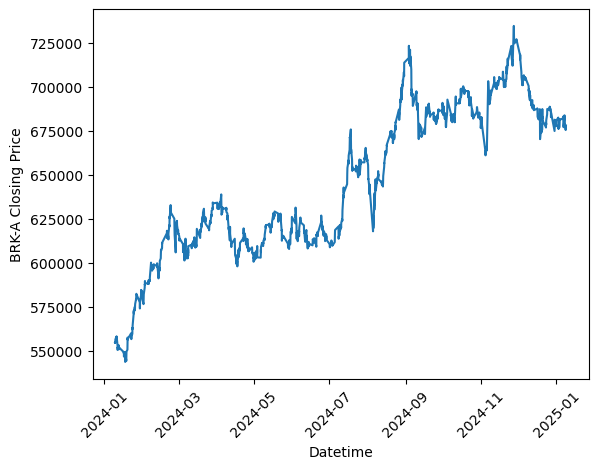

In [65]:
line_plot(BRK_A_short_data)

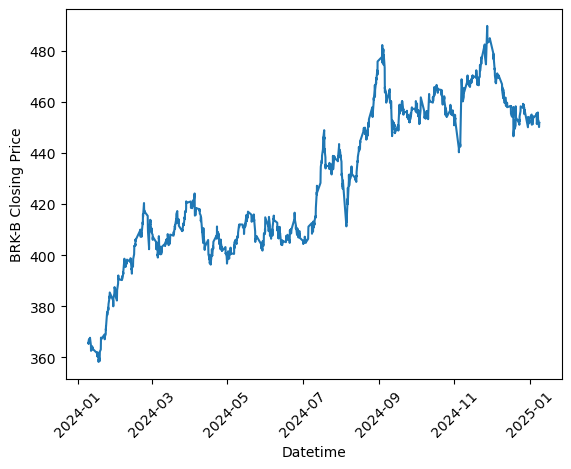

In [66]:
line_plot(BRK_B_short_data)

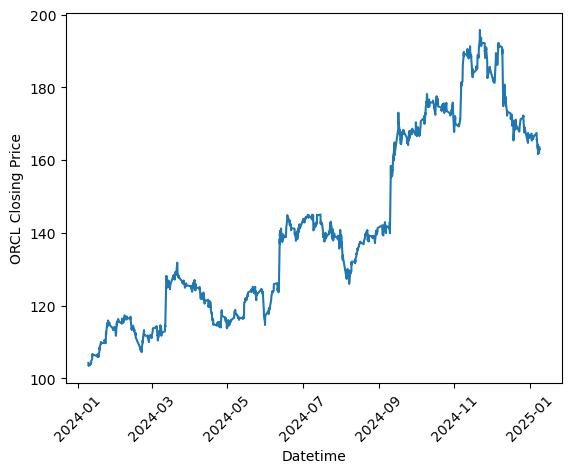

In [67]:
line_plot(ORACLE_short_data)

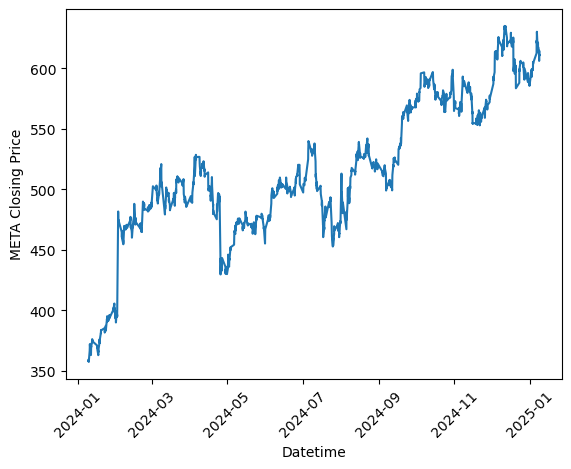

In [68]:
line_plot(META_short_data)

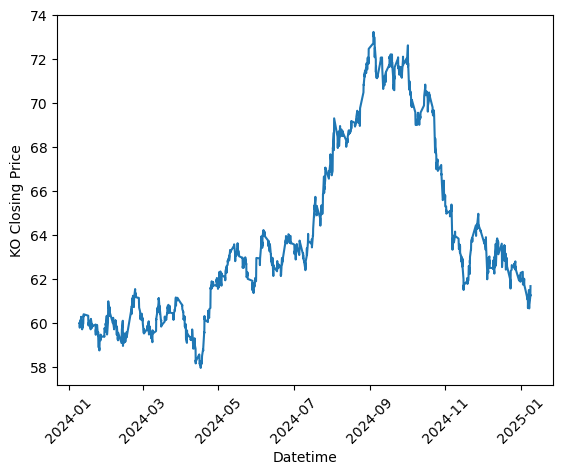

In [69]:
line_plot(COCA_short_data)

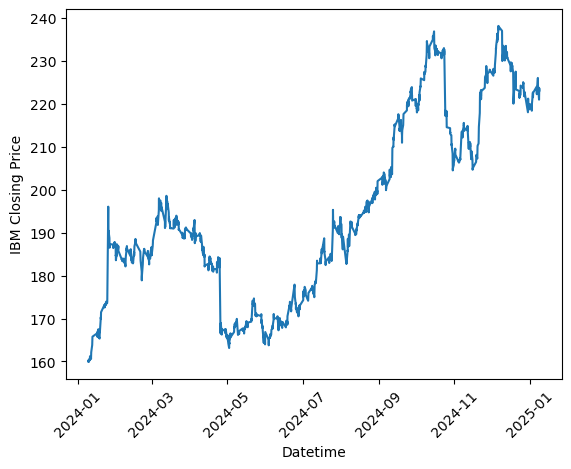

In [70]:
line_plot(IBM_short_data)

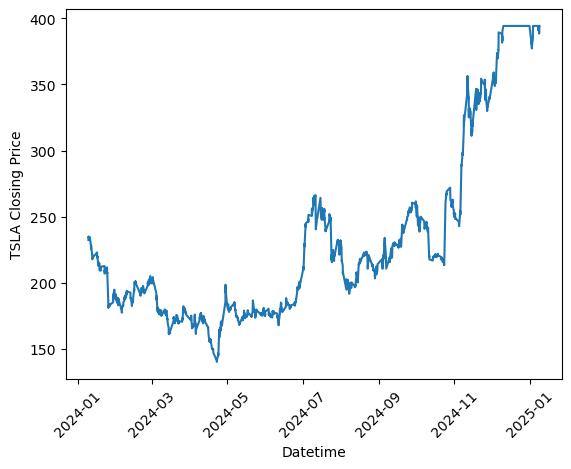

In [71]:
line_plot(TESLA_short_data)

### Bivariate EDA

#### correlation between stock prices

In [72]:
# examining the correlation between the two BRK stock classes closing prices
BRK_A_short_data[("Close", "BRK-A")].corr(BRK_B_short_data[("Close", "BRK-B")])

0.9996922555095591

There is a high correlation between BRK-A and BRK-B closing prices. It makes sense to include on in the other model

In [73]:
# examining the correlation between the closing price of XLF (financial sector) and all the stocks
BRK_A_short_data[("Close", "XLF")].corr(ORACLE_short_data[("Close", "ORCL")])

0.9385008536187577

In [74]:
BRK_A_short_data[("Close", "XLF")].corr(META_short_data[("Close", "META")])

0.8697029600685461

In [75]:
BRK_A_short_data[("Close", "XLF")].corr(COCA_short_data[("Close", "KO")])

0.43308389402772784

In [76]:
BRK_A_short_data[("Close", "XLF")].corr(IBM_short_data[("Close", "IBM")])

0.8446910360887774

In [77]:
BRK_A_short_data[("Close", "XLF")].corr(TESLA_short_data[("Close", "TSLA")])

0.8262483218076321

Whether positive or negative, there is a strong correlation between the closing prices of all stocks and the closing price of the financial sector (XLF), even for the stocks that are not in the financial sector.

In [78]:
# examining the correlation between TESLA and ORACLE closing prices
TESLA_short_data[("Close", "TSLA")].corr(ORACLE_short_data[("Close", "ORCL")])

0.7735653821587033

In [79]:
# examining the correlation between IBM and ORACLE closing prices
IBM_short_data[("Close", "IBM")].corr(ORACLE_short_data[("Close", "ORCL")])

0.848609748816433

In [80]:
# examining the correlation between IBM and META closing prices
IBM_short_data[("Close", "IBM")].corr(META_short_data[("Close", "META")])

0.8372008820121624

There is correlations between the closing prices of tesla and oracle, oracle and IBM, IBM and META. This arises as some of these stocks move together, and some are competitors.

#### relation between closing price and trading volume

In [81]:
# examining the relationship between closing prices and 
BRK_A_short_data[("Close", "BRK-A")].corr(BRK_A_short_data[("Volume", "BRK-A")])

-0.25373100422650713

<Axes: xlabel="('Close', 'BRK-A')", ylabel="('Volume', 'BRK-A')">

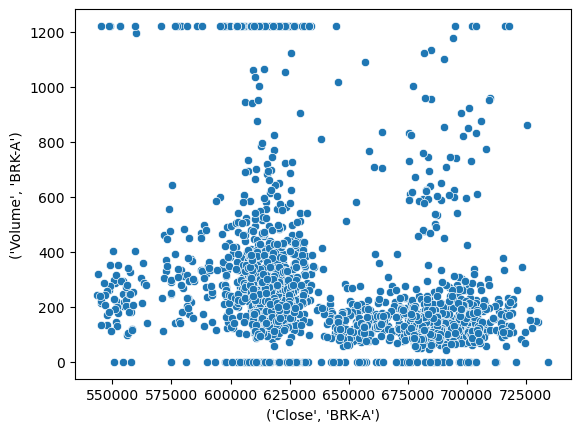

In [82]:
# checking for non-linear relation
sns.scatterplot(x=BRK_A_short_data[("Close", "BRK-A")], y=BRK_A_short_data[("Volume", "BRK-A")])

In [83]:
BRK_B_short_data[("Close", "BRK-B")].corr(BRK_B_short_data[("Volume", "BRK-B")])


0.08784194988111031

<Axes: xlabel="('Close', 'BRK-B')", ylabel="('Volume', 'BRK-B')">

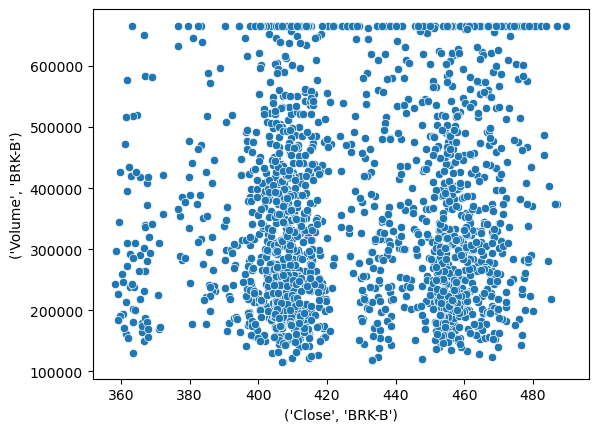

In [84]:
sns.scatterplot(x=BRK_B_short_data[("Close", "BRK-B")], y=BRK_B_short_data[("Volume", "BRK-B")])

In [85]:
ORACLE_short_data[("Close", "ORCL")].corr(ORACLE_short_data[("Volume", "ORCL")])


0.022436465174304924

<Axes: xlabel="('Close', 'ORCL')", ylabel="('Volume', 'ORCL')">

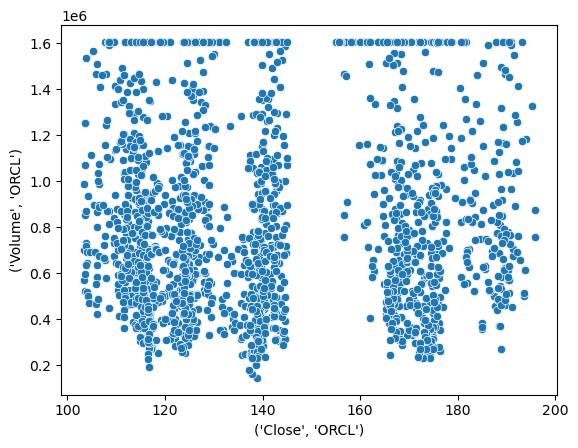

In [86]:
sns.scatterplot(x=ORACLE_short_data[("Close", "ORCL")], y=ORACLE_short_data[("Volume", "ORCL")])

In [87]:
META_short_data[("Close", "META")].corr(META_short_data[("Volume", "META")])


-0.254634558896997

<Axes: xlabel="('Close', 'META')", ylabel="('Volume', 'META')">

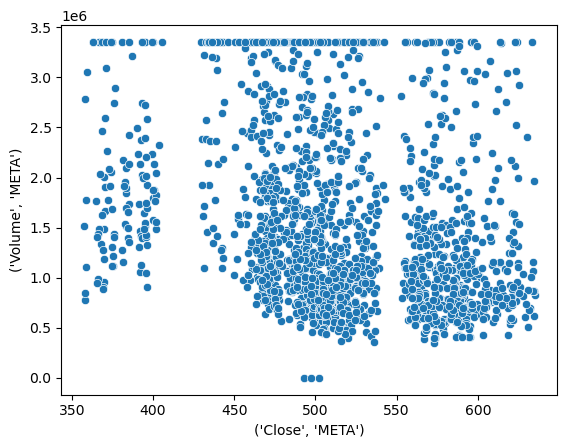

In [88]:
sns.scatterplot(x=META_short_data[("Close", "META")], y=META_short_data[("Volume", "META")])

In [89]:
COCA_short_data[("Close", "KO")].corr(COCA_short_data[("Volume", "KO")])


-0.045201300334508095

<Axes: xlabel="('Close', 'KO')", ylabel="('Volume', 'KO')">

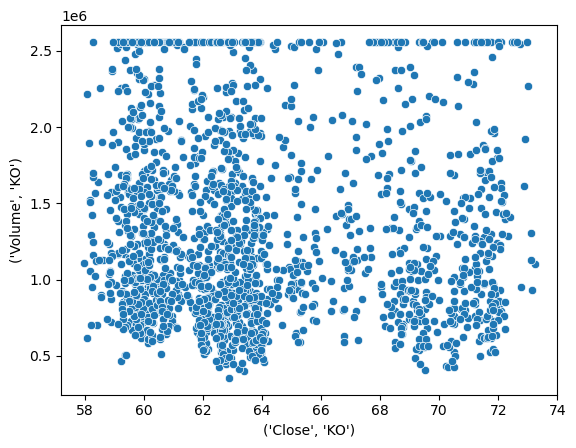

In [90]:
sns.scatterplot(x=COCA_short_data[("Close", "KO")], y=COCA_short_data[("Volume", "KO")])

In [91]:
IBM_short_data[("Close", "IBM")].corr(IBM_short_data[("Volume", "IBM")])


-0.028893129951435614

<Axes: xlabel="('Close', 'IBM')", ylabel="('Volume', 'IBM')">

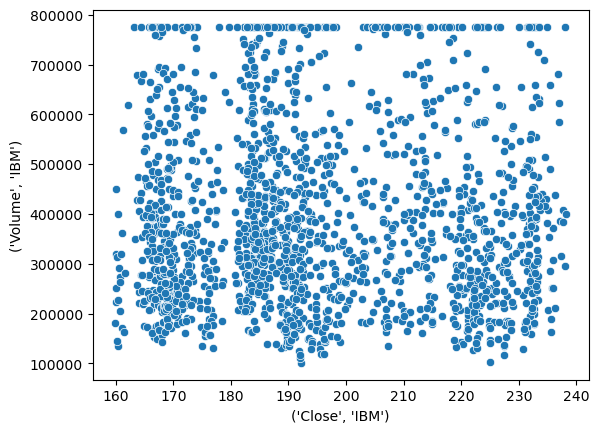

In [92]:
sns.scatterplot(x=IBM_short_data[("Close", "IBM")], y=IBM_short_data[("Volume", "IBM")])

In [93]:
TESLA_short_data[("Close", "TSLA")].corr(TESLA_short_data[("Volume", "TSLA")])


0.02534178575916796

<Axes: xlabel="('Close', 'TSLA')", ylabel="('Volume', 'TSLA')">

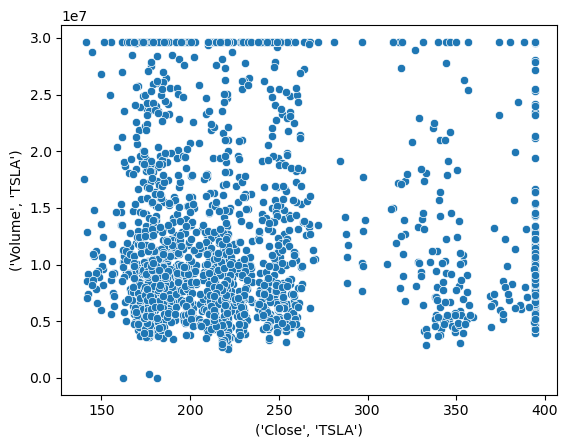

In [94]:
sns.scatterplot(x=TESLA_short_data[("Close", "TSLA")], y=TESLA_short_data[("Volume", "TSLA")])

It appears there actually isn't a huge relation with trading volumes and closing prices. It may require feature engineering to make trading volumes have effect on the model. Or may be, trading volumes aren't that predictive for the model actually.

# Reorganizing the data for each stock into a simpler shape

In [95]:
# simplifying data shapes and selecting only column we are going to use after this
def get_simple_data(data, additional_columns):
    """
    This function extracts important columns from multi-level column data, 
    concatenates them with additional columns from other data specified 
    by the user as dictionaries, and returns the concatenated data.

    The main goal is to simplify the shape of our stock data.

    Parameters:
    data (pd.DataFrame): The original DataFrame with multi-level columns.
    additional_columns (dict or pd.DataFrame): The additional columns to concatenate with 'data'.

    Returns:
    pd.DataFrame: The concatenated DataFrame containing selected columns and the additional data.
    """

    # Extract tickers from the multi-level column structure
    ticker = data.columns[0][1]
    ticker_2 = data.columns[1][1]
    ticker_3 = data.columns[2][1]

    # Select relevant columns from the multi-level DataFrame
    simple_data = pd.DataFrame({
        "Close" : data[("Close", ticker)],
        "Open" : data[("Open", ticker)],
        "Low" : data[("Low", ticker)],
        "High" : data[("High", ticker)],
        "Volume" : data[("Volume", ticker)],
        ticker_2 : data[("Close", ticker_2)],
        ticker_3 : data[("Close", ticker_3)]
    }, index=data.index)

    # Handle the additional columns
    additional_data = pd.DataFrame(additional_columns)

    # Concatenate the simple data with the additional data
    full_data = pd.concat([simple_data, additional_data], axis=1)
    return full_data


In [96]:
BRK_A_additional_column = {"BRK_B" : BRK_B_short_data[("Close", "BRK-B")]}
BRK_A = get_simple_data(BRK_A_short_data, BRK_A_additional_column)
BRK_A.head()

,Close,Open,Low,High,Volume,XLF,^GSPC,BRK_B
Datetime,,,,,,,,
2024-01-09 14:30:00+00:00,554624.6875,558396.0,553270.000,559315.0,0.0,37.715000,4742.029785,365.549988
2024-01-09 15:30:00+00:00,554662.5000,554365.0,554172.000,555330.5,294.0,37.755001,4749.799805,365.619995
2024-01-09 16:30:00+00:00,554695.0000,554425.0,554042.375,555495.0,247.0,37.764999,4758.859863,365.980011
2024-01-09 17:30:00+00:00,554386.1875,555095.0,554100.000,555705.0,205.0,37.705002,4755.279785,365.434998
2024-01-09 18:30:00+00:00,555122.5000,554100.0,553600.000,555899.0,219.0,37.689899,4752.899902,366.100006


In [97]:
BRK_B_additional_column = {"BRK_A": BRK_A_short_data[("Close", "BRK-A")]}
BRK_B = get_simple_data(BRK_B_short_data, BRK_B_additional_column)
BRK_B.head()

,Close,Open,Low,High,Volume,XLF,^GSPC,BRK_A
Datetime,,,,,,,,
2024-01-09 14:30:00+00:00,365.549988,368.000000,364.769989,368.000000,417948.0,37.715000,4742.029785,554624.6875
2024-01-09 15:30:00+00:00,365.619995,365.489990,365.279999,365.864990,217933.0,37.755001,4749.799805,554662.5000
2024-01-09 16:30:00+00:00,365.980011,365.579987,365.399994,366.130005,179916.0,37.764999,4758.859863,554695.0000
2024-01-09 17:30:00+00:00,365.434998,366.015015,365.399994,366.209991,290077.0,37.705002,4755.279785,554386.1875
2024-01-09 18:30:00+00:00,366.100006,365.410004,365.119995,366.440002,164346.0,37.689899,4752.899902,555122.5000


In [98]:
ORACLE_additional_columns = {"XLF" : BRK_A_short_data[("Close", "XLF")],
                             "IBM" : IBM_short_data[("Close", "IBM")],
                             "TSLA" : TESLA_short_data[("Close", "TSLA")]}
ORACLE = get_simple_data(ORACLE_short_data, ORACLE_additional_columns)
ORACLE.head()

,Close,Open,Low,High,Volume,XLK,^GSPC,XLF,IBM,TSLA
Datetime,,,,,,,,,,
2024-01-09 14:30:00+00:00,104.250000,103.849998,103.550003,104.480003,934825.0,187.850006,4742.029785,37.715000,160.039993,232.324997
2024-01-09 15:30:00+00:00,103.870003,104.250000,103.690002,104.339996,731208.0,188.460007,4749.799805,37.755001,160.119995,234.295197
2024-01-09 16:30:00+00:00,104.000000,103.870003,103.750000,104.099998,645300.0,189.070007,4758.859863,37.764999,160.339996,234.919998
2024-01-09 17:30:00+00:00,103.480003,104.000000,103.480003,104.050003,569294.0,189.080002,4755.279785,37.705002,159.899994,234.154602
2024-01-09 18:30:00+00:00,103.389999,103.480003,103.290001,103.620003,701062.0,188.950104,4752.899902,37.689899,159.994995,233.898804


In [99]:
META_additional_columns = {
    "XLF" : BRK_B_short_data[("Close", "XLF")],
    "IBM" : IBM_short_data[("Close", "IBM")]
}
META = get_simple_data(META_short_data, META_additional_columns)
META.head()

,Close,Open,Low,High,Volume,XLK,^IXIC,XLF,IBM
Datetime,,,,,,,,,
2024-01-09 14:30:00+00:00,358.369995,356.399994,355.359985,358.549988,2787889.0,187.850006,14769.126953,37.715000,160.039993
2024-01-09 15:30:00+00:00,358.559998,358.399994,357.260010,359.739990,1777361.0,188.460007,14820.863281,37.755001,160.119995
2024-01-09 16:30:00+00:00,359.369995,358.576996,358.299988,360.640015,3055328.0,189.070007,14860.784180,37.764999,160.339996
2024-01-09 17:30:00+00:00,358.734985,359.380005,358.416412,359.899994,1110313.0,189.080002,14861.980469,37.705002,159.899994
2024-01-09 18:30:00+00:00,358.209991,358.730011,357.940002,358.959991,782285.0,188.950104,14851.020508,37.689899,159.994995


In [100]:
COCA_additional_columns = {"XLF" : BRK_B_short_data[("Close", "XLF")]}
COCA = get_simple_data(COCA_short_data, COCA_additional_columns)
COCA.head()

,Close,Open,Low,High,Volume,XLP,^GSPC,XLF
Datetime,,,,,,,,
2024-01-09 14:30:00+00:00,60.009998,59.990002,59.619999,60.029999,1464998.0,72.294998,4742.029785,37.715000
2024-01-09 15:30:00+00:00,60.025002,60.005001,59.980000,60.134998,778285.0,72.379997,4749.799805,37.755001
2024-01-09 16:30:00+00:00,59.884998,60.029999,59.855000,60.070000,776768.0,72.389999,4758.859863,37.764999
2024-01-09 17:30:00+00:00,59.790001,59.888100,59.740601,59.910000,688077.0,72.324997,4755.279785,37.705002
2024-01-09 18:30:00+00:00,59.799999,59.790001,59.750000,59.930000,1024204.0,72.470001,4752.899902,37.689899


In [101]:
IBM_additional_columns = {
    "XLF" : BRK_B_short_data[("Close", "XLF")],
    "ORCL" : ORACLE_short_data[("Close", "ORCL")],
    "META" : META_short_data[("Close", "META")]
}
IBM = get_simple_data(IBM_short_data, IBM_additional_columns)
IBM.head()

,Close,Open,Low,High,Volume,XLK,^GSPC,XLF,ORCL,META
Datetime,,,,,,,,,,
2024-01-09 14:30:00+00:00,160.039993,160.000000,159.509995,160.399994,319107.0,187.850006,4742.029785,37.715000,104.250000,358.369995
2024-01-09 15:30:00+00:00,160.119995,160.059998,159.820007,160.220001,222615.0,188.460007,4749.799805,37.755001,103.870003,358.559998
2024-01-09 16:30:00+00:00,160.339996,160.145004,160.029999,160.483704,226837.0,189.070007,4758.859863,37.764999,104.000000,359.369995
2024-01-09 17:30:00+00:00,159.899994,160.339996,159.860001,160.350006,181182.0,189.080002,4755.279785,37.705002,103.480003,358.734985
2024-01-09 18:30:00+00:00,159.994995,159.889999,159.679993,160.195007,250629.0,188.950104,4752.899902,37.689899,103.389999,358.209991


In [102]:
TESLA_additional_column = {
    "XLF" : BRK_B_short_data[("Close", "XLF")],
    "ORCL" : ORACLE_short_data[("Close", "ORCL")]
}
TESLA = get_simple_data(TESLA_short_data, TESLA_additional_column)
TESLA.head()

,Close,Open,Low,High,Volume,XLY,^IXIC,XLF,ORCL
Datetime,,,,,,,,,
2024-01-09 14:30:00+00:00,232.324997,238.110001,232.039993,238.964600,29647688.37,174.059998,14769.126953,37.715000,104.250000
2024-01-09 15:30:00+00:00,234.295197,232.316406,232.199997,235.289993,16237364.00,174.539993,14820.863281,37.755001,103.870003
2024-01-09 16:30:00+00:00,234.919998,234.300003,233.649994,235.580002,12078110.00,174.835007,14860.784180,37.764999,104.000000
2024-01-09 17:30:00+00:00,234.154602,234.949997,233.820007,235.429993,9092026.00,174.779999,14861.980469,37.705002,103.480003
2024-01-09 18:30:00+00:00,233.898804,234.175003,233.309998,235.139999,9923972.00,174.619995,14851.020508,37.689899,103.389999


# Feature Engineering

### accounting for holidays

Stock prices change when they are before and after holidays. We have chosen the range within 5 days before or after holidays to be the deciding range for days near holidays. Five is a sweet spot as stocks prices change for 3 up to 7 days before and after holidays, and five is in the middle. 

In [103]:
def get_holiday_columns(data):
    """
    Adds holiday-related columns to a DataFrame and plots correlations.

    This function retrieves public holidays in the United States within the date range 
    of the given DataFrame's index, calculates 5 days before and after each holiday, 
    and adds two new columns to the DataFrame: 
    - "Before_Holiday": Indicates whether the date is within 5 days before a holiday.
    - "After_Holiday": Indicates whether the date is within 5 days after a holiday.

    Additionally, it visualizes the correlation of the "Close" column with the new columns 
    using a heatmap.

    Parameters:
        data (pandas.DataFrame): A pandas DataFrame with a DatetimeIndex and a "Close" column.

    Returns:
        pandas.DataFrame: The original DataFrame with the added "Before_Holiday" and 
                          "After_Holiday" columns.
    Notes:
        - The function uses the `UnitedStates` holiday calendar from the `holidays` package.
        - The holiday range extends to include dates before the next year's Christmas 
          for accurate handling of year-end holidays.
        - The correlation heatmap provides insights into the relationships between 
          the closing price and holiday proximity.
          """
    # getting a numpy array of all the holidays in united states for the years in our data
    calendar = UnitedStates()
    holidays = list()
    for year in range(data.index.min().year, data.index.max().year + 2): #+2 to consider the days before next year's christmas
        holidays.extend(calendar.holidays(year))
    holidays = np.array([holiday[0] for holiday in holidays])

    # identifying date ranges for 5 days before and after the holiday
    before_holiday = np.concatenate([holidays - pd.Timedelta(days=day) for day in range(1, 6)])
    after_holiday = np.concatenate([holidays + pd.Timedelta(days=day) for day in range(1, 6)])

    # Consider the holiday itself as part of the before holiday array.
    before_holiday = np.concatenate((holidays, before_holiday))

    # Adding dummy values columns based on before_holiday and after_holiday
    data["Before_Holiday"] = np.where(np.isin(data.index.date, before_holiday), 1, 0)
    data["After_Holiday"] = np.where(np.isin(data.index.date, after_holiday), 1, 0)
    print("Two columns added.")

    # plotting correlation
    sns.heatmap(data[["Close", "Before_Holiday", "After_Holiday"]].corr(), annot=True)
    plt.show()
    

Two columns added.


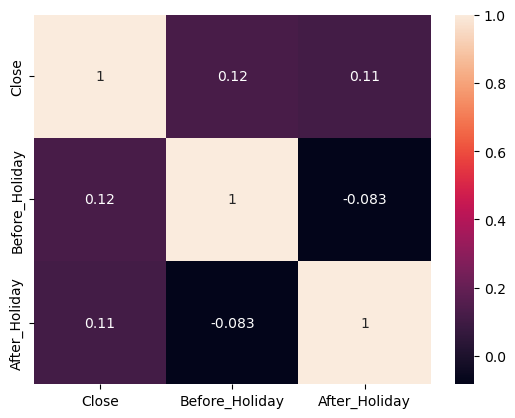

In [104]:
get_holiday_columns(BRK_A)

Two columns added.


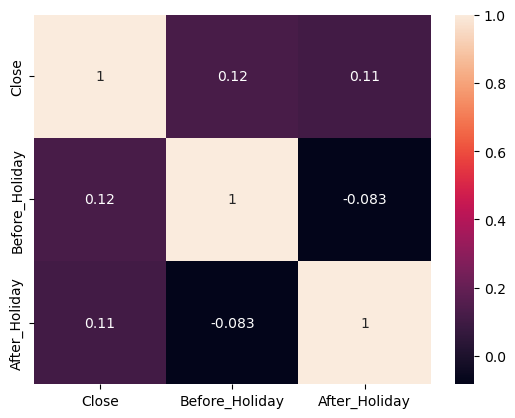

In [105]:
get_holiday_columns(BRK_B)

Two columns added.


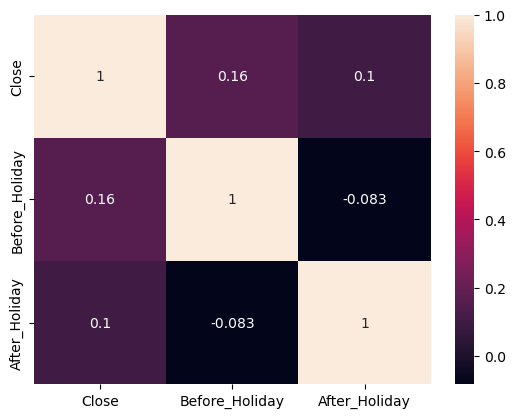

In [106]:
get_holiday_columns(ORACLE)

Two columns added.


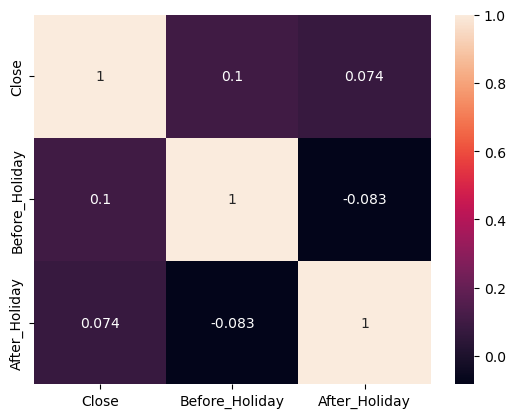

In [107]:
get_holiday_columns(META)

Two columns added.


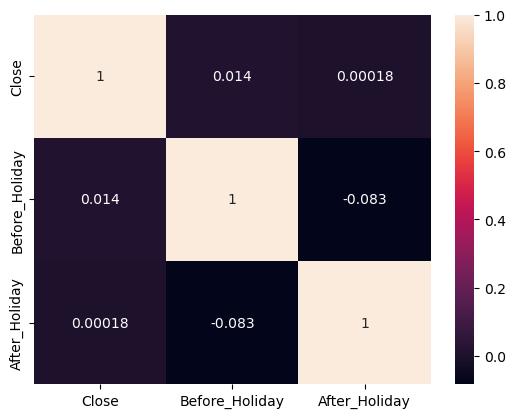

In [108]:
get_holiday_columns(COCA)

Two columns added.


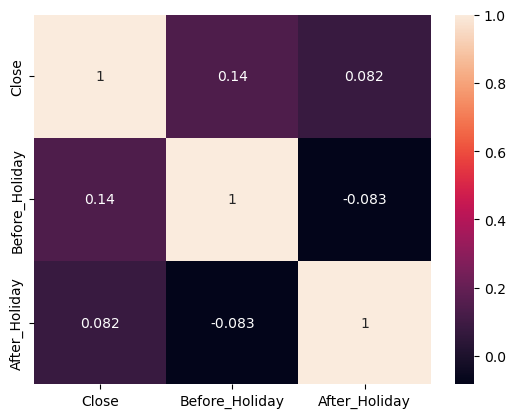

In [109]:
get_holiday_columns(IBM)

Two columns added.


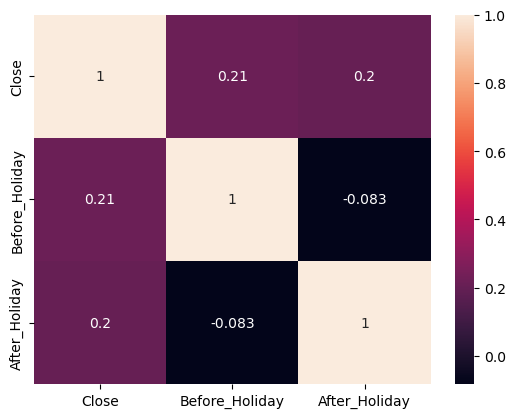

In [110]:
get_holiday_columns(TESLA)

### other features (moving averages, volatility, trend)


- The Exponential Moving Average (EMA) places more weight on recent data, making it more responsive to short-term price changes. It is useful for short-term forecasting and momentum analysis as it quickly reacts to market shifts.
- Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. RSI values range from 0 to 100 and are calculated over a specified period (commonly 14 periods). It is a technical indicator widely used to assess whether a stock or asset is overbought or oversold.
- separate columns for day of week and month to capture trends related to time and seasonality.
- Bollinger Bands are a technical analysis tool that provides a visual representation of a stock's price volatility and potential overbought or oversold conditions. Wider bands indicate higher volatility, while narrower bands indicate lower volatility.
- MACD (Moving Average Convergence Divergence) is a momentum indicator that shows the relationship between two moving averages of a stock's price. It is a popular technical analysis tool used to identify potential buy or sell signals by highlighting changes in momentum.
- The Average True Range (ATR) is a technical indicator that measures market volatility. It does not provide directional information but rather indicates the degree of price movement over a given period.
- The Volume-Weighted Average Price (VWAP) is a technical indicator used in financial markets to assess the average price of a security throughout a trading day, based on both its price and trading volume. It gives a more accurate representation of the average price at which a stock is traded, considering the quantity of shares traded at different price levels.



In [111]:
def feature_engineering(data, ema_span=20, rsi_window=14, bb_window=20, macd_fast=12, macd_slow=26, atr_window=14):
    """
    Perform feature engineering on a stock market DataFrame by adding common technical indicators.

    This function adds the following features to the input DataFrame:
        - Exponential Moving Average (EMA) based on the closing price.
        - Relative Strength Index (RSI) based on the closing price.
        - Day of the week (integer representation: 0 = Monday, ..., 6 = Sunday).
        - Month of the year (integer representation: 1 = January, ..., 12 = December).
        - Bollinger Bands (Lower and Upper) based on the closing price.
        - Moving Average Convergence Divergence (MACD) based on the closing price.
        - Average True Range (ATR) based on the high, low, and close prices.
        - Volume Weighted Average Price (VWAP) based on high, low, close prices, and volume.

    Parameters:
    ----------
    data : pandas.DataFrame
        Input DataFrame containing stock market data with the following columns:
        - 'Open', 'High', 'Low', 'Close', and 'Volume'.
        The DataFrame index must be a pandas DateTimeIndex.

    ema_span : int, optional (default=20)
        The window size for calculating the Exponential Moving Average (EMA).

    rsi_window : int, optional (default=14)
        The window size for calculating the Relative Strength Index (RSI).

    bb_window : int, optional (default=20)
        The window size for calculating Bollinger Bands (Lower and Upper).

    macd_fast : int, optional (default=12)
        The fast window size for calculating the MACD line.

    macd_slow : int, optional (default=26)
        The slow window size for calculating the MACD line.

    atr_window : int, optional (default=14)
        The window size for calculating the Average True Range (ATR).

    Returns:
    -------
    pandas.DataFrame
        A modified DataFrame with the added technical indicators as new columns.
        The first `max(ema_span, rsi_window, bb_window, macd_slow, atr_window)` rows are dropped 
        to account for incomplete rolling window calculations.

    Notes:
    -----
    - The function modifies the input DataFrame in place but also returns it for flexibility.
    - The function also fills generated missing values using mean/median.

    Example:
    --------
    >>> import pandas as pd
    >>> import yfinance as yf
    >>> from ta import add_all_ta_features
    >>> df = yf.download("AAPL", start="2023-01-01", end="2023-12-31")
    >>> df = feature_engineering(df)
    >>> print(df.head())
    """
    data["EMA"] = data["Close"].ewm(span=ema_span).mean()
    data["Day_of_week"] = data.index.day_of_week
    data["Hour"] = data.index.hour
    data["Day_of_week_sin"] = np.sin(2 * np.pi * data["Day_of_week"] / 7) # cyclic_encoding
    data["Day_of_week_cos"] = np.cos(2 * np.pi * data["Day_of_week"] / 7) 
    data["Hour_sin"] = np.sin(2 * np.pi * data["Hour"] / 24)
    data["Hour_cos"] = np.cos(2 * np.pi * data["Hour"] / 24)


    # dropping the columns used for encoding as they are not needed anymore
    data = data.drop(columns=["Day_of_week", "Hour"])

    data["BB_Low"] = ta.volatility.bollinger_lband(data["Close"], window=bb_window)
    data["BB_High"] = ta.volatility.bollinger_hband(data["Close"], window=bb_window)
    data["MACD"] = ta.trend.macd(data["Close"], window_fast=macd_fast, window_slow=macd_slow)
    data["ATR"] = ta.volatility.average_true_range(data["High"], data["Low"], data["Close"], window=atr_window)

    # Calculate the Typical Price
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3

    # Calculate the product of Typical Price and Volume
    price_by_volume = typical_price * data['Volume']

    # Calculate cumulative sums for VWAP
    cumulative_price_by_volume = price_by_volume.cumsum()
    cumulative_volume = data['Volume'].cumsum()

    # Calculate VWAP
    data['VWAP'] = cumulative_price_by_volume / cumulative_volume

    data.reset_index(inplace=True)
    data.drop(['Volume'], axis=1, inplace=True) # volume has been found to not be a strong indicator
    # New calculated feature will have some missing values and outliers
    # the following code deals with them
    means  = data.mean().to_dict() # getting mean for each column
    medians = data.median().to_dict() # getting median for each column
    outlier_columns = get_columns_outliers(data) # getting columns with outliers

    # filling missing values accordingly
    for column in data.columns:
        if column in outlier_columns:
            data[column] = data[column].fillna(medians[column])
        else:
            data[column] = data[column].fillna(means[column])

    return data

In [112]:
BRK_A = feature_engineering(BRK_A)
BRK_A.head()

c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Datetime,Close,Open,Low,High,XLF,^GSPC,BRK_B,Before_Holiday,After_Holiday,EMA,Day_of_week_sin,Day_of_week_cos,Hour_sin,Hour_cos,BB_Low,BB_High,MACD,ATR,VWAP
0,2024-01-09 14:30:00+00:00,554624.6875,558396.0,553270.000,559315.0,37.715000,4742.029785,365.549988,0,0,554624.687500,0.781831,0.62349,-0.500000,-8.660254e-01,637305.796655,652384.627256,476.946904,0.0,607506.283022
1,2024-01-09 15:30:00+00:00,554662.5000,554365.0,554172.000,555330.5,37.755001,4749.799805,365.619995,0,0,554644.539062,0.781831,0.62349,-0.707107,-7.071068e-01,637305.796655,652384.627256,476.946904,0.0,554721.666667
2,2024-01-09 16:30:00+00:00,554695.0000,554425.0,554042.375,555495.0,37.764999,4758.859863,365.980011,0,0,554663.068016,0.781831,0.62349,-0.866025,-5.000000e-01,637305.796655,652384.627256,476.946904,0.0,554731.920287
3,2024-01-09 17:30:00+00:00,554386.1875,555095.0,554100.000,555705.0,37.705002,4755.279785,365.434998,0,0,554583.136892,0.781831,0.62349,-0.965926,-2.588190e-01,637305.796655,652384.627256,476.946904,0.0,554731.501368
4,2024-01-09 18:30:00+00:00,555122.5000,554100.0,553600.000,555899.0,37.689899,4752.899902,366.100006,0,0,554713.604238,0.781831,0.62349,-1.000000,-1.836970e-16,637305.796655,652384.627256,476.946904,0.0,554763.802612


In [113]:
BRK_B = feature_engineering(BRK_B)
BRK_B.head()

c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Datetime,Close,Open,Low,High,XLF,^GSPC,BRK_A,Before_Holiday,After_Holiday,EMA,Day_of_week_sin,Day_of_week_cos,Hour_sin,Hour_cos,BB_Low,BB_High,MACD,ATR,VWAP
0,2024-01-09 14:30:00+00:00,365.549988,368.000000,364.769989,368.000000,37.715000,4742.029785,554624.6875,0,0,365.549988,0.781831,0.62349,-0.500000,-8.660254e-01,423.632181,433.712118,0.346909,0.0,366.106659
1,2024-01-09 15:30:00+00:00,365.619995,365.489990,365.279999,365.864990,37.755001,4749.799805,554662.5000,0,0,365.586742,0.781831,0.62349,-0.707107,-7.071068e-01,423.632181,433.712118,0.346909,0.0,365.929013
2,2024-01-09 16:30:00+00:00,365.980011,365.579987,365.399994,366.130005,37.764999,4758.859863,554695.0000,0,0,365.731148,0.781831,0.62349,-0.866025,-5.000000e-01,423.632181,433.712118,0.346909,0.0,365.908648
3,2024-01-09 17:30:00+00:00,365.434998,366.015015,365.399994,366.209991,37.705002,4755.279785,554386.1875,0,0,365.645654,0.781831,0.62349,-0.965926,-2.588190e-01,423.632181,433.712118,0.346909,0.0,365.849108
4,2024-01-09 18:30:00+00:00,366.100006,365.410004,365.119995,366.440002,37.689899,4752.899902,555122.5000,0,0,365.755558,0.781831,0.62349,-1.000000,-1.836970e-16,423.632181,433.712118,0.346909,0.0,365.853968


In [114]:
ORACLE = feature_engineering(ORACLE)
ORACLE.head()

c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Datetime,Close,Open,Low,High,XLK,^GSPC,XLF,IBM,TSLA,...,EMA,Day_of_week_sin,Day_of_week_cos,Hour_sin,Hour_cos,BB_Low,BB_High,MACD,ATR,VWAP
0,2024-01-09 14:30:00+00:00,104.250000,103.849998,103.550003,104.480003,187.850006,4742.029785,37.715000,160.039993,232.324997,...,104.250000,0.781831,0.62349,-0.500000,-8.660254e-01,138.752201,144.863266,0.147568,0.0,104.093335
1,2024-01-09 15:30:00+00:00,103.870003,104.250000,103.690002,104.339996,188.460007,4749.799805,37.755001,160.119995,234.295197,...,104.050501,0.781831,0.62349,-0.707107,-7.071068e-01,138.752201,144.863266,0.147568,0.0,104.037742
2,2024-01-09 16:30:00+00:00,104.000000,103.870003,103.750000,104.099998,189.070007,4758.859863,37.764999,160.339996,234.919998,...,104.031958,0.781831,0.62349,-0.866025,-5.000000e-01,138.752201,144.863266,0.147568,0.0,104.013245
3,2024-01-09 17:30:00+00:00,103.480003,104.000000,103.480003,104.050003,189.080002,4755.279785,37.705002,159.899994,234.154602,...,103.872617,0.781831,0.62349,-0.965926,-2.588190e-01,138.752201,144.863266,0.147568,0.0,103.945411
4,2024-01-09 18:30:00+00:00,103.389999,103.480003,103.290001,103.620003,188.950104,4752.899902,37.689899,159.994995,233.898804,...,103.755876,0.781831,0.62349,-1.000000,-1.836970e-16,138.752201,144.863266,0.147568,0.0,103.845179


In [115]:
META = feature_engineering(META)
META.head()

c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Datetime,Close,Open,Low,High,XLK,^IXIC,XLF,IBM,Before_Holiday,...,EMA,Day_of_week_sin,Day_of_week_cos,Hour_sin,Hour_cos,BB_Low,BB_High,MACD,ATR,VWAP
0,2024-01-09 14:30:00+00:00,358.369995,356.399994,355.359985,358.549988,187.850006,14769.126953,37.715000,160.039993,0,...,358.369995,0.781831,0.62349,-0.500000,-8.660254e-01,502.072799,526.7433,1.082144,0.0,357.426656
1,2024-01-09 15:30:00+00:00,358.559998,358.399994,357.260010,359.739990,188.460007,14820.863281,37.755001,160.119995,0,...,358.469746,0.781831,0.62349,-0.707107,-7.071068e-01,502.072799,526.7433,1.082144,0.0,357.852321
2,2024-01-09 16:30:00+00:00,359.369995,358.576996,358.299988,360.640015,189.070007,14860.784180,37.764999,160.339996,0,...,358.800312,0.781831,0.62349,-0.866025,-5.000000e-01,502.072799,526.7433,1.082144,0.0,358.487534
3,2024-01-09 17:30:00+00:00,358.734985,359.380005,358.416412,359.899994,189.080002,14861.980469,37.705002,159.899994,0,...,358.781453,0.781831,0.62349,-0.965926,-2.588190e-01,502.072799,526.7433,1.082144,0.0,358.554883
4,2024-01-09 18:30:00+00:00,358.209991,358.730011,357.940002,358.959991,188.950104,14851.020508,37.689899,159.994995,0,...,358.643222,0.781831,0.62349,-1.000000,-1.836970e-16,502.072799,526.7433,1.082144,0.0,358.539680


In [116]:
COCA = feature_engineering(COCA)
COCA.head()

c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Datetime,Close,Open,Low,High,XLP,^GSPC,XLF,Before_Holiday,After_Holiday,EMA,Day_of_week_sin,Day_of_week_cos,Hour_sin,Hour_cos,BB_Low,BB_High,MACD,ATR,VWAP
0,2024-01-09 14:30:00+00:00,60.009998,59.990002,59.619999,60.029999,72.294998,4742.029785,37.715000,0,0,60.009998,0.781831,0.62349,-0.500000,-8.660254e-01,63.390857,64.695391,-0.015866,0.0,59.886665
1,2024-01-09 15:30:00+00:00,60.025002,60.005001,59.980000,60.134998,72.379997,4749.799805,37.755001,0,0,60.017875,0.781831,0.62349,-0.707107,-7.071068e-01,63.390857,64.695391,-0.015866,0.0,59.942176
2,2024-01-09 16:30:00+00:00,59.884998,60.029999,59.855000,60.070000,72.389999,4758.859863,37.764999,0,0,59.969083,0.781831,0.62349,-0.866025,-5.000000e-01,63.390857,64.695391,-0.015866,0.0,59.940759
3,2024-01-09 17:30:00+00:00,59.790001,59.888100,59.740601,59.910000,72.324997,4755.279785,37.705002,0,0,59.917385,0.781831,0.62349,-0.965926,-2.588190e-01,63.390857,64.695391,-0.015866,0.0,59.917151
4,2024-01-09 18:30:00+00:00,59.799999,59.790001,59.750000,59.930000,72.470001,4752.899902,37.689899,0,0,59.888990,0.781831,0.62349,-1.000000,-1.836970e-16,63.390857,64.695391,-0.015866,0.0,59.897568


In [117]:
IBM = feature_engineering(IBM)
IBM.head()

c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Datetime,Close,Open,Low,High,XLK,^GSPC,XLF,ORCL,META,...,EMA,Day_of_week_sin,Day_of_week_cos,Hour_sin,Hour_cos,BB_Low,BB_High,MACD,ATR,VWAP
0,2024-01-09 14:30:00+00:00,160.039993,160.000000,159.509995,160.399994,187.850006,4742.029785,37.715000,104.250000,358.369995,...,160.039993,0.781831,0.62349,-0.500000,-8.660254e-01,191.72172,198.367796,0.233717,0.0,159.983327
1,2024-01-09 15:30:00+00:00,160.119995,160.059998,159.820007,160.220001,188.460007,4749.799805,37.755001,103.870003,358.559998,...,160.081994,0.781831,0.62349,-0.707107,-7.071068e-01,191.72172,198.367796,0.233717,0.0,160.012096
2,2024-01-09 16:30:00+00:00,160.339996,160.145004,160.029999,160.483704,189.070007,4758.859863,37.764999,104.000000,359.369995,...,160.176731,0.781831,0.62349,-0.866025,-5.000000e-01,191.72172,198.367796,0.233717,0.0,160.092514
3,2024-01-09 17:30:00+00:00,159.899994,160.339996,159.860001,160.350006,189.080002,4755.279785,37.705002,103.480003,358.734985,...,160.096841,0.781831,0.62349,-0.965926,-2.588190e-01,191.72172,198.367796,0.233717,0.0,160.081860
4,2024-01-09 18:30:00+00:00,159.994995,159.889999,159.679993,160.195007,188.950104,4752.899902,37.689899,103.389999,358.209991,...,160.072206,0.781831,0.62349,-1.000000,-1.836970e-16,191.72172,198.367796,0.233717,0.0,160.055720


In [118]:
TESLA = feature_engineering(TESLA)
TESLA.head()

c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Datetime,Close,Open,Low,High,XLY,^IXIC,XLF,ORCL,Before_Holiday,...,EMA,Day_of_week_sin,Day_of_week_cos,Hour_sin,Hour_cos,BB_Low,BB_High,MACD,ATR,VWAP
0,2024-01-09 14:30:00+00:00,232.324997,238.110001,232.039993,238.964600,174.059998,14769.126953,37.715000,104.250000,0,...,232.324997,0.781831,0.62349,-0.500000,-8.660254e-01,202.591889,220.728684,0.194709,0.0,234.443197
1,2024-01-09 15:30:00+00:00,234.295197,232.316406,232.199997,235.289993,174.539993,14820.863281,37.755001,103.870003,0,...,233.359352,0.781831,0.62349,-0.707107,-7.071068e-01,202.591889,220.728684,0.194709,0.0,234.261024
2,2024-01-09 16:30:00+00:00,234.919998,234.300003,233.649994,235.580002,174.835007,14860.784180,37.764999,104.000000,0,...,233.932412,0.781831,0.62349,-0.866025,-5.000000e-01,202.591889,220.728684,0.194709,0.0,234.355968
3,2024-01-09 17:30:00+00:00,234.154602,234.949997,233.820007,235.429993,174.779999,14861.980469,37.705002,103.480003,0,...,233.996555,0.781831,0.62349,-0.965926,-2.588190e-01,202.591889,220.728684,0.194709,0.0,234.371186
4,2024-01-09 18:30:00+00:00,233.898804,234.175003,233.309998,235.139999,174.619995,14851.020508,37.689899,103.389999,0,...,233.972910,0.781831,0.62349,-1.000000,-1.836970e-16,202.591889,220.728684,0.194709,0.0,234.338322


# Model Selection

### LSTM

##### general function and a class for LSTM

we can't randomly split sequential data as it cal lead to leakage in to the future

In [119]:
# function to split data to training and testing data
def split_test_val_train(data, test_size=0.15, val_size=0.15):
    """
    Split sequential data into train, validation, and test sets.
    
    Args:
        data (DataFrame): The input sequential data.
        test_size (float): Fraction of data to use as the test set.
        val_size (float): Fraction of training data to use as the validation set.
    
    Returns:
        tuple: (data_train, data_val, data_test)
    """

    # Calculate test splitting index
    test_splitting_index = int(data.shape[0] * (1 - test_size))
    data_train_val = data.iloc[:test_splitting_index]
    data_test = data.iloc[test_splitting_index:]

    # Calculate validation splitting index for the remaining train set
    val_splitting_index = int(data_train_val.shape[0] * (1 - val_size))
    data_train = data_train_val.iloc[:val_splitting_index]
    data_val = data_train_val.iloc[val_splitting_index:]
    return data_train, data_val, data_test

why -3?... we are predicting the target column, instead of the close one. 

The main issue with predicting actual values in time series is that time series data tends to exhibit patterns such as trends, seasonality, and autocorrelation. Predicting the actual value at a future time point can be challenging because:

Noise and Complexity: Time series data often contains significant noise or irregular fluctuations. Predicting the exact value can be difficult, as noise can obscure the underlying patterns. By predicting the difference (or change) between consecutive values, you focus on modeling the pattern of the changes rather than trying to capture the overall value at a future point.

Stationarity and Differencing: A common assumption in time series forecasting is that the data is stationary, meaning its statistical properties (like mean and variance) don't change over time. If the original data isn't stationary, you can "difference" the data (predict the change between consecutive points) to make it stationary. This makes the series easier to model and forecast. Predicting the difference between values often leads to more stable and predictable behavior, which can be easier to model using techniques like ARIMA.

Long-Term Trends: Predicting actual values often requires accounting for long-term trends that may change over time, making the task more complex. Predicting differences instead of absolute values removes the need to explicitly account for long-term trends, and instead, the model learns the changes from one period to the next, which are often more stable.

Accuracy and Error Propagation: Directly predicting actual values can lead to cumulative prediction errors over time. Small errors in earlier predictions can propagate and grow as you predict further into the future. In contrast, predicting differences reduces the compounding of errors because each prediction only depends on the change, not the accumulated forecast.

In summary, by predicting differences (or changes) between consecutive data points, you make the model's task easier, focusing on patterns and trends rather than exact values. This generally leads to better predictive performance, especially for time series data with noise, non-stationarity, or complex trends.

Assuming a sequence length of 10:

x would be an array of the previous 10 stock prices (20 minutes of historical data).

y would be the stock price at the 12th minute (2 minutes after the last price in x).

In [120]:
def get_sequence(data, seq_length=10):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i : (i+seq_length), 1:]
        y = data.iloc[(i+seq_length), 1]

        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [121]:
def get_dataloader(X, y, batch_size=32, shuffle=False):
    data = TensorDataset(
        torch.from_numpy(X).float(),
        torch.from_numpy(y).float()
    )
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return dataloader

In [122]:
# building the model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2):
        super().__init__()
        self.LSTM = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        outputs, _ = self.LSTM(x)
        output = self.fc(outputs[:, -1, :]) # use the last time step
        return output

 instead of using a standard loss value you should use mean absolute percentage error because if a stock is trading at 1$ and you have a loss of 1$ you would be off by 100% but if its trading at 1000$ and yoru loss is 10 then you would be off by 1%. But we will still use MSELoss. Here is the reason: Sensitive to Small Values: MAPE is a percentage-based error, and it can behave very poorly if the true value (y_true) is small or zero. For very small true values, the percentage error can become extremely large, causing MAPE to give misleading results. And we are trying to predict differences, which are really small.

In [123]:
def train_and_test(data, lr=0.0001, epochs=200, test_model=False, test_size=0.15, val_size=0.15, seq_length=10, batch_size=32, shuffle=False, hidden_size=32, num_layers=2):
    """
    Train and test an LSTM model for time series forecasting with separate scalers for features and target.

    Parameters:
        Same as before.

    Returns:
        net (torch.nn.Module): The trained LSTM model.
    """
    # Splitting the data
    train, val, test = split_test_val_train(data, test_size=test_size, val_size=val_size)

    # Separate scalers for features and target
    feature_scaler = MinMaxScaler(feature_range=(0,1))
    target_scaler = MinMaxScaler(feature_range=(0,1))

    # Fit scalers
    train_features = train.iloc[:, 2:]  # Features
    train_target = train.iloc[:, 1].values.reshape(-1, 1)  # Target (e.g., "Close")

    train_features_scaled = feature_scaler.fit_transform(train_features)
    train_target_scaled = target_scaler.fit_transform(train_target)

    val_features = val.iloc[:, 2:]
    val_target = val.iloc[:, 1].values.reshape(-1, 1)

    val_features_scaled = feature_scaler.transform(val_features)
    val_target_scaled = target_scaler.transform(val_target)

    test_features = test.iloc[:, 2:]
    test_target = test.iloc[:, 1].values.reshape(-1, 1)

    test_features_scaled = feature_scaler.transform(test_features)
    test_target_scaled = target_scaler.transform(test_target)

    # Combine scaled features and target into a single DataFrame for sequence generation
    train_scaled = pd.DataFrame(np.hstack([train_target_scaled, train_features_scaled]))
    val_scaled = pd.DataFrame(np.hstack([val_target_scaled, val_features_scaled]))
    test_scaled = pd.DataFrame(np.hstack([test_target_scaled, test_features_scaled]))

    # Getting sequence data for training and validation sets
    train_X, train_y = get_sequence(train_scaled, seq_length=seq_length)
    val_X, val_y = get_sequence(val_scaled, seq_length=seq_length)
    input_size = train_X.shape[2]
    # Getting dataloaders for training and validation sets
    train_dataloader = get_dataloader(train_X, train_y, batch_size=batch_size, shuffle=shuffle)
    val_dataloader = get_dataloader(val_X, val_y, batch_size=batch_size, shuffle=shuffle)

    # Training LSTM
    net = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)


    for epoch in range(epochs):
        # Training
        net.train()
        for seqs, labels in train_dataloader:
            labels = labels.view(batch_size, 1)
            outputs = net(seqs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Validating
        net.eval()
        val_loss = 0
        with torch.no_grad():
            for val_seqs, val_labels in val_dataloader:
                val_labels = val_labels.view(batch_size, 1)
                val_outputs = net(val_seqs)

                # Inverse transform predictions and labels
                # val_outputs = target_scaler.inverse_transform(val_outputs.cpu().numpy())
                # val_labels = target_scaler.inverse_transform(val_labels.cpu().numpy())

                # Calculate loss in original scale
                val_loss += criterion(val_outputs, val_labels).item()
            val_loss /= len(val_dataloader)  # Average validation loss
        print(f"Epoch {epoch+1}: Training Loss = {loss.item():.4f}, Validation Loss = {val_loss:.4f}")

    # Using test set to evaluate the model
    if test_model:
        test_X, test_y = get_sequence(test_scaled, seq_length=seq_length)
        test_dataloader = get_dataloader(test_X, test_y, batch_size=batch_size, shuffle=shuffle)
        
        mse = torchmetrics.MeanSquaredError()
        net.eval()
        with torch.no_grad():
            for test_seqs, test_labels in test_dataloader:
                outputs = net(test_seqs).squeeze()
                
                # Inverse transform predictions and true values
                outputs_inv = target_scaler.inverse_transform(outputs.cpu().numpy().reshape(-1, 1))
                test_labels_inv = target_scaler.inverse_transform(test_labels.cpu().numpy().reshape(-1, 1))

                mse(torch.tensor(outputs_inv), torch.tensor(test_labels_inv))
        test_mse = mse.compute()

        print(f"Test MSE: {test_mse}")
        print(f"Data's original variance: {data["Close"].var()}")

    # getting the last sequence for future predictions
    last_sequence = test_scaled.iloc[-seq_length:, 1:].values

    return net, last_sequence, target_scaler


In [124]:
def predict_future(net, initial_sequence, num_predictions, target_scaler):
    """
    Predict future values iteratively using a trained LSTM model.

    Parameters:
        net (torch.nn.Module): Trained LSTM model.
        initial_sequence (ndarray): The last sequence used for prediction (scaled).
        num_predictions (int): Number of future predictions.
        target_scaler (MinMaxScaler): Scaler used for target.

    Returns:
        predictions (list): Predicted future values in original scale.
    """
    net.eval()
    predictions = []
    current_sequence = torch.tensor(initial_sequence, dtype=torch.float32)

    with torch.no_grad():
        for _ in range(num_predictions):
            # Predict the next value
            next_value = net(current_sequence.unsqueeze(0)).cpu().numpy()
            predictions.append(target_scaler.inverse_transform(next_value)[0, 0])
            
            # Update the sequence for the next prediction
            next_row = current_sequence[-1].clone()
            next_row[0] = float(next_value[0,0])
            next_row = next_row.reshape(1, -1)
            current_sequence = torch.tensor(np.vstack([current_sequence[1:], next_row]))

    return np.array(predictions)


A decreasing validation loss indicates the model is learning and generalizing well.
An increasing validation loss while training loss decreases indicates overfitting.

In [129]:
model, last_sequence, target_scaler = train_and_test(ORACLE, test_model=True, lr=0.0001, epochs=30, num_layers=10)

Epoch 1: Training Loss = 0.5835, Validation Loss = 0.7333
Epoch 2: Training Loss = 0.4804, Validation Loss = 0.6161
Epoch 3: Training Loss = 0.3878, Validation Loss = 0.5088
Epoch 4: Training Loss = 0.3286, Validation Loss = 0.4399
Epoch 5: Training Loss = 0.3076, Validation Loss = 0.4162
Epoch 6: Training Loss = 0.3023, Validation Loss = 0.4105
Epoch 7: Training Loss = 0.3007, Validation Loss = 0.4090
Epoch 8: Training Loss = 0.3001, Validation Loss = 0.4085
Epoch 9: Training Loss = 0.2998, Validation Loss = 0.4083
Epoch 10: Training Loss = 0.2996, Validation Loss = 0.4082
Epoch 11: Training Loss = 0.2994, Validation Loss = 0.4081
Epoch 12: Training Loss = 0.2992, Validation Loss = 0.4079
Epoch 13: Training Loss = 0.2990, Validation Loss = 0.4078
Epoch 14: Training Loss = 0.2988, Validation Loss = 0.4076
Epoch 15: Training Loss = 0.2985, Validation Loss = 0.4072
Epoch 16: Training Loss = 0.2980, Validation Loss = 0.4067
Epoch 17: Training Loss = 0.2972, Validation Loss = 0.4057
Epoch 

In [126]:
num_preds = 591
preds = predict_future(model, initial_sequence=last_sequence, target_scaler=target_scaler, num_predictions=num_preds)

In [127]:
model, last_sequence, target_scaler = train_and_test(data, test_model=True, lr=0.0001, epochs=15, num_layers=10)

NameError: name 'data' is not defined

In [268]:
model2 = train_and_test(TESLA, test_model=True, lr=0.00001, epochs=15, num_layers=10)

Epoch 1: Training Loss = 0.9178, Validation Loss = 0.6301
Epoch 2: Training Loss = 0.8893, Validation Loss = 0.6066
Epoch 3: Training Loss = 0.8608, Validation Loss = 0.5833
Epoch 4: Training Loss = 0.8314, Validation Loss = 0.5593
Epoch 5: Training Loss = 0.8003, Validation Loss = 0.5340
Epoch 6: Training Loss = 0.7670, Validation Loss = 0.5071
Epoch 7: Training Loss = 0.7306, Validation Loss = 0.4778
Epoch 8: Training Loss = 0.6902, Validation Loss = 0.4454
Epoch 9: Training Loss = 0.6442, Validation Loss = 0.4089
Epoch 10: Training Loss = 0.5903, Validation Loss = 0.3665
Epoch 11: Training Loss = 0.5253, Validation Loss = 0.3161
Epoch 12: Training Loss = 0.4460, Validation Loss = 0.2560
Epoch 13: Training Loss = 0.3538, Validation Loss = 0.1885
Epoch 14: Training Loss = 0.2602, Validation Loss = 0.1237
Epoch 15: Training Loss = 0.1833, Validation Loss = 0.0748
Test MSE: 229.10153198242188
Data's original variance: 1091.9568014130914


In [248]:
model2 = train_and_test(ORACLE.drop(columns=["XLK", "^GSPC", "XLF", "IBM", "TSLA"]), test_model=True, lr=0.00001, epochs=15, num_layers=10)

[0.91499544 0.94293529 0.95576769 ... 0.26326029 0.25850048 0.26160484]
Epoch 1: Training Loss = 0.1050, Validation Loss = 0.0515
Epoch 2: Training Loss = 0.0985, Validation Loss = 0.0474
Epoch 3: Training Loss = 0.0919, Validation Loss = 0.0432
Epoch 4: Training Loss = 0.0852, Validation Loss = 0.0391
Epoch 5: Training Loss = 0.0786, Validation Loss = 0.0352
Epoch 6: Training Loss = 0.0718, Validation Loss = 0.0312
Epoch 7: Training Loss = 0.0650, Validation Loss = 0.0274
Epoch 8: Training Loss = 0.0579, Validation Loss = 0.0236
Epoch 9: Training Loss = 0.0506, Validation Loss = 0.0199
Epoch 10: Training Loss = 0.0429, Validation Loss = 0.0164
Epoch 11: Training Loss = 0.0348, Validation Loss = 0.0130
Epoch 12: Training Loss = 0.0264, Validation Loss = 0.0102
Epoch 13: Training Loss = 0.0178, Validation Loss = 0.0083
Epoch 14: Training Loss = 0.0098, Validation Loss = 0.0082
Epoch 15: Training Loss = 0.0035, Validation Loss = 0.0112
[[166.87169]
 [166.96304]
 [167.00362]
 [167.03915]


# Prophet

In [310]:
data_train = ORACLE[["Datetime", "Close"]].copy()

In [311]:
from prophet import Prophet
data_train = data_train.rename(columns={"Datetime" : "ds",
                           "Close" : "y"})

In [313]:
# Remove timezone information
data_train['ds'] = data_train['ds'].dt.tz_localize(None)



In [315]:
data_train, data_val, data_test = split_test_val_train(data_train)

In [316]:
model = Prophet()
model.fit(data_train)

12:55:42 - cmdstanpy - INFO - Chain [1] start processing
12:55:50 - cmdstanpy - INFO - Chain [1] done processing


In [344]:
data_val.shape[0] + data_test.shape[0]

1112

In [327]:
future = model.make_future_dataframe(periods=1112)
future

,ds
0,2024-12-04 14:30:00
1,2024-12-04 14:32:00
2,2024-12-04 14:34:00
3,2024-12-04 14:36:00
4,2024-12-04 14:38:00
...,...
4000,2028-01-08 16:24:00
4001,2028-01-09 16:24:00
4002,2028-01-10 16:24:00
4003,2028-01-11 16:24:00


In [329]:
preds = model.predict(future)

In [330]:
preds["yhat"].shape

(4005,)

In [331]:
pred_train, pred_val, pred_test = split_test_val_train(preds[["yhat"]])

In [341]:
pred_test

,yhat
3404,276.515145
3405,281.743579
3406,278.551475
3407,275.378814
3408,278.011458
...,...
4000,404.448769
4001,401.256664
4002,398.084004
4003,400.716647


In [334]:
data_test

,ds,y
3404,2024-12-30 20:28:00,167.195007
3405,2024-12-30 20:30:00,167.229996
3406,2024-12-30 20:32:00,167.255005
3407,2024-12-30 20:34:00,167.199203
3408,2024-12-30 20:36:00,167.190002
...,...,...
4000,2025-01-03 20:50:00,165.800003
4001,2025-01-03 20:52:00,165.770004
4002,2025-01-03 20:54:00,166.145004
4003,2025-01-03 20:56:00,166.169998


There is a bigg difference between the predicted future and the test future

When using multiple features (also known as regressors) in Prophet, you need to provide their future values for the period you want to predict. This is because Prophet cannot forecast the future values of additional regressors on its own; it only uses them as inputs to improve its forecast of the target variable. This is a big problem and we don't want this problem.

The plots below show a wide confidence interval. Too wide to be useful.

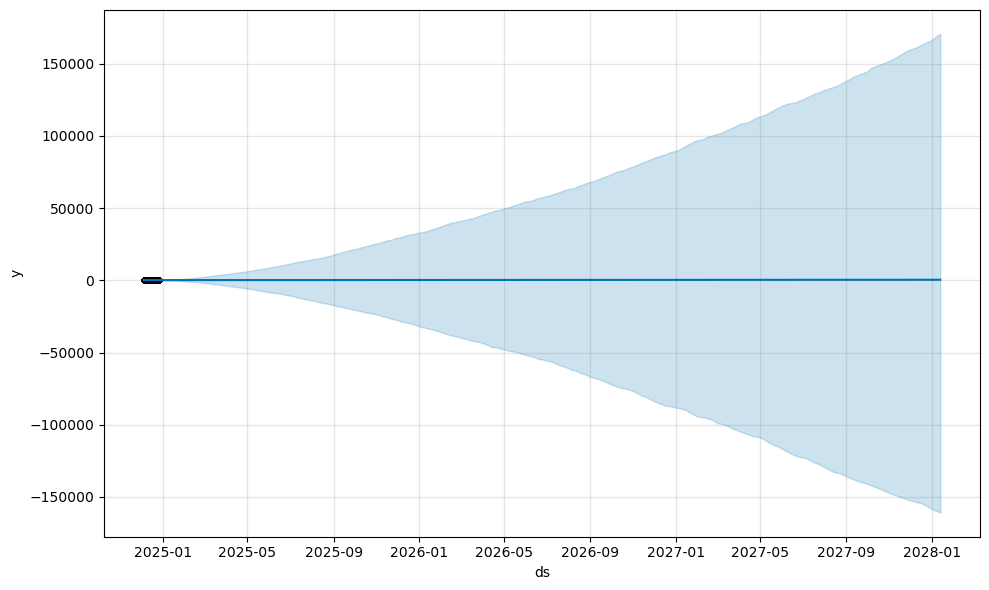

In [342]:
plot = model.plot(preds)

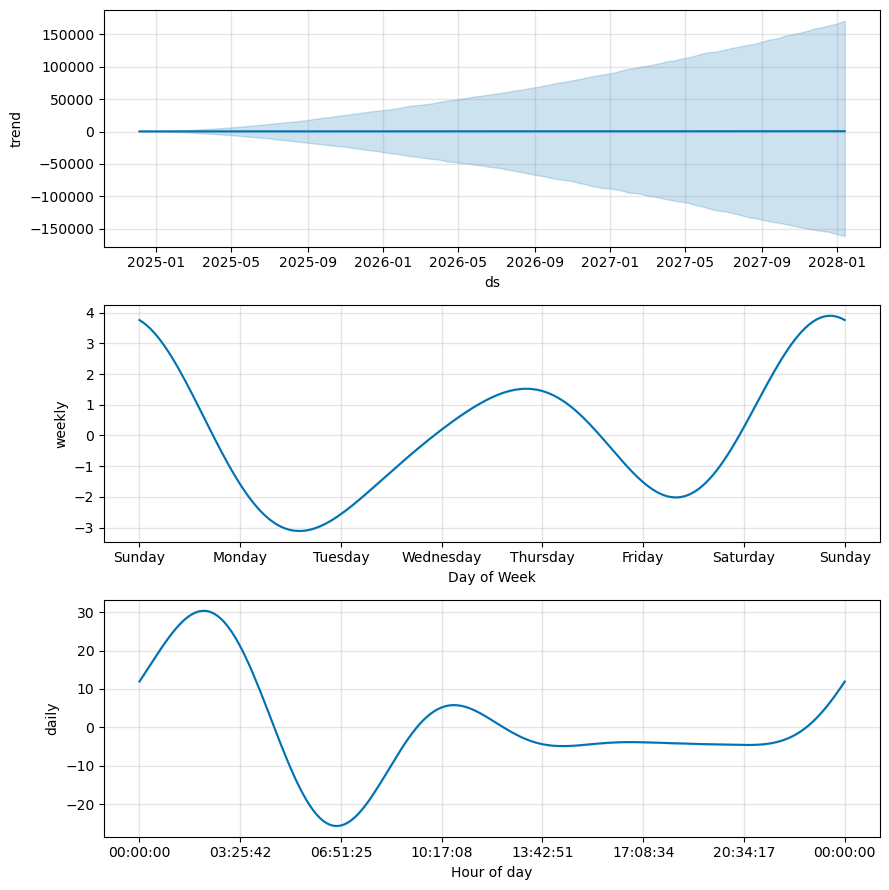

In [343]:
fig2 = model.plot_components(preds)

use the validation loss consistency for the fine tuning section

predict future days and see how accurate they are

# ARIMA

(4005, 1)
(21795, 1)
(4005, 1)


c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\envs\testenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

Close    0
dtype: int64
0
RMSE: 0.08690437152509674


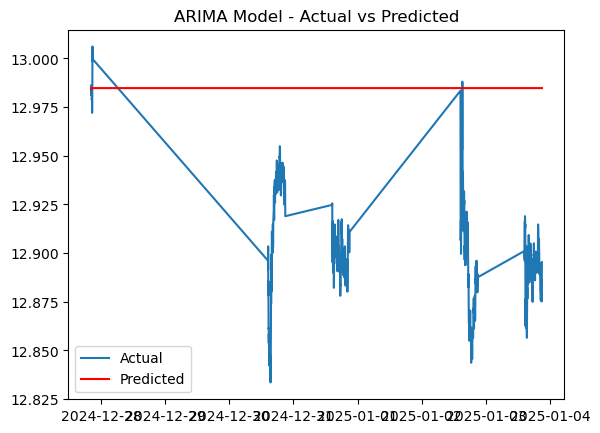

In [161]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# For demonstration, let's assume 'Close' column is the target
y = ORACLE[['Close', "Datetime"]].set_index("Datetime")
print(y.shape)
y["Close"] = np.sqrt(y["Close"])
y.index = pd.to_datetime(y.index)  # Ensure the index is datetime
y = y.asfreq('2min')  # Set frequency to 2-minute intervals

print(y.shape)

y = y.dropna()
print(y.shape)

# Split the data into training and test sets
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

# Step 2: Fit ARIMA Model
# ARIMA model order (p, d, q) - you may need to optimize this based on your data
# p = autoregressive terms, d = differencing order, q = moving average terms
model = ARIMA(train, order=(5, 1, 0))  # Example: (p=5, d=1, q=0)
model_fit = model.fit()

# Step 3: Make Predictions
# Predict on the test set
forecast = model_fit.forecast(steps=len(test))

print(test.isna().sum())
print(forecast.isna().sum())

# Step 4: Evaluate the Model
# Calculate RMSE (Root Mean Squared Error)
rmse = sqrt(mean_squared_error(test, forecast))
print(f'RMSE: {rmse}')

# Optional: Plot the actual vs predicted values
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.legend()
plt.title('ARIMA Model - Actual vs Predicted')
plt.show()